In [3]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM,TimeDistributed, Lambda, Flatten, SimpleRNN, GRU, Bidirectional
import math
from sklearn.metrics import mean_squared_error
from tensorflow.keras.utils import plot_model
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
import matplotlib.pyplot as plt
import numpy as np

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from glob import glob

log_total = [pd.read_csv(f) for f in glob('/content/drive/MyDrive/PRACA_INŻYNIERSKA_DANE/4_preprocessed_data/*.csv')]

log_total

In [102]:
import glob
path = '/content/drive/MyDrive/PRACA_INŻYNIERSKA_DANE/4_preprocessed_data' # use your path
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files[:-1]:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

frame = pd.concat(li, axis=0, ignore_index=True)

In [5]:
path = '/content/drive/MyDrive/PRACA_INŻYNIERSKA_DANE/4_preprocessed_data/WEYS.csv'
df = pd.read_csv(path,  sep=',')

In [6]:
def preprocess(df: pd.DataFrame):
   # df on input should contain only one column with the price data (plus dataframe index)
    df = df['avg_price']
    min = df.min()
    max = df.max()
    x = df 
    # time series normalization part
    # y will be a column in a dataframe
    y = (x - min) / (max - min)
    return y, min, max

In [7]:
WINDOW_SIZE = 6*30
BATCH_SIZE = 32
AUTOTUNE = tf.data.experimental.AUTOTUNE
STEPS_AHEAD = 3*30

In [8]:
test_split = 0.2
len = df.shape[0]
split_point = int(len * (1 - test_split))

# splitting dataframe by row index
train = df.iloc[:split_point,:]
test = df.iloc[split_point-WINDOW_SIZE:,:]

#preprocess function call for training set
train, min, max = preprocess(train)

#preprocessing on test set
test = test.avg_price
test = (test - min) / (max - min)

In [9]:
#funkcja do przetwarzania danych i wczytywania do pamięci
def windowed_dataset(ds:tf.data.Dataset, window_size=WINDOW_SIZE, batch_size=BATCH_SIZE):
  #podzial na okna - z 'odcieciem' konca pliku
  #okna długości rok i 90 dni
  ds = ds.window(window_size + STEPS_AHEAD, shift=1, drop_remainder=True)
    #w każdym punkcie pojawia się nowe okno (shift=1)
    #ostatnie wskazania nie są wycinkami tego wycinka (okno byłoby na krótkie - drop_remainder=true)
  ds = ds.flat_map(lambda w: w.batch(window_size + STEPS_AHEAD)) #usuwanie nadmiarowych nawiasów
  #x i y
  #x to cały wycinek poza wartością predykowaną, y są wartości predykowane
  #num_parallel_calls=AUTOTUNE - wykonywanie wielowątkowe i pakowanie w paczki i mieszanie
  ds = ds.map(lambda w: (w[:-STEPS_AHEAD].reshape(-1,1), w[-STEPS_AHEAD:]), 
              num_parallel_calls=AUTOTUNE)
  return ds.shuffle(100).batch(batch_size)


#funkcja do wczytywania pliku
def csv_reader_dataset(df, repeat=None, batch_size=32):
  #bierze potrzebne kolumny, konwert do float64 dataset
  dataset = tf.data.Dataset.from_tensor_slices((
            tf.cast(df.values, tf.float64)))
  #podzial na okna
  dataset = windowed_dataset(dataset)
  #pakowanie paczek do pamięci cash
  return dataset.prefetch(AUTOTUNE)

In [10]:
ds_train = csv_reader_dataset(train)
ds_test = csv_reader_dataset(test)

In [10]:
for batch in ds_train.take(1):
  print(batch)

  #shape=(16, 365, 1) - 16 paczek, po 365 dni w każdej, punkty rozpoczęcia paczek nie są znane
#shape=(16, 90) - dalej mamy po 90 wskazań dla każdej paczki

(<tf.Tensor: shape=(32, 180, 1), dtype=float64, numpy=
array([[[0.36187258],
        [0.36127685],
        [0.36068112],
        ...,
        [0.45738188],
        [0.45282302],
        [0.48007813]],

       [[0.52940386],
        [0.52621551],
        [0.48700597],
        ...,
        [0.72063846],
        [0.7235767 ],
        [0.72651494]],

       [[0.49288353],
        [0.46319835],
        [0.43351316],
        ...,
        [0.46404577],
        [0.47085654],
        [0.4931606 ]],

       ...,

       [[0.63044892],
        [0.61003067],
        [0.57967222],
        ...,
        [0.90022817],
        [0.8548231 ],
        [0.80941803]],

       [[0.34893339],
        [0.41013732],
        [0.43041493],
        ...,
        [0.50956509],
        [0.53663294],
        [0.54581243]],

       [[0.62075208],
        [0.62595287],
        [0.63676777],
        ...,
        [0.66198799],
        [0.69047349],
        [0.91158908]]])>, <tf.Tensor: shape=(32, 90), dtype=float64, numpy

In [18]:
def denormalize(x):
  return [i * (max - min) + min for i in x]

In [19]:
def show_sample_predictions(model):
  for batch in ds_test.take(1):
    predictions = model.predict(batch[0]) #robi się dla całego batcha na raz
    for i in range(BATCH_SIZE): #dla wszystkich 16 batchy
      ts = range(WINDOW_SIZE + STEPS_AHEAD) #czas płynie w zakresie od 0 do, windows_size+steps_ahead
      xs = batch[0][i].numpy().reshape(-1) # z bierzemy z batcha, x są pierwsze 0, i-te wskazanie
      ys = batch[1][i].numpy()#ten numpy robi konwersje na numpy
      true = denormalize(np.concatenate((xs, ys), axis=0)) #to nwm co robi

      predicted = denormalize(predictions[i])#kolejne predykcje
      ts_predicted = range(WINDOW_SIZE, WINDOW_SIZE + STEPS_AHEAD)#czas trwania predykcji

      for i in range(3):
        print("Mean for {} month = {}".format(i, np.mean(predicted[10*i:10*(i+1)])))

      fig= plt.figure(figsize=(10,3))#a tutaj szerokość i długość wukresu
      plt.plot(ts, true, "b", ts_predicted, predicted, "g")
      
      plt.ylim(min,max) #zakres y od min do max
      plt.show()

#LSTM models

In [ ]:
# LSTM + Dense
# LSTM x2 + Dense
# LSTM x2
# LSTM x3

LSTM + DENSE

In [26]:
def create_model_lstm_dense():
  model = Sequential([
                      LSTM(36, input_shape=(WINDOW_SIZE, 1), return_sequences=False),
                      Dense(STEPS_AHEAD,  name='output', activation='sigmoid')])

  model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(), metrics=['mae'])
  return model 

model = create_model_lstm_dense()
callback = tf.keras.callbacks.EarlyStopping(monitor='loss',  patience=30, restore_best_weights=True)
history = model.fit(ds_train, epochs=200, verbose=1,  callbacks=[callback])

Epoch 1/200
117/117 [==============================] - 2s 9ms/step - loss: 0.0464 - mae: 0.1746
Epoch 2/200
117/117 [==============================] - 1s 8ms/step - loss: 0.0423 - mae: 0.1696
Epoch 3/200
117/117 [==============================] - 1s 8ms/step - loss: 0.0391 - mae: 0.1635
Epoch 4/200
117/117 [==============================] - 1s 8ms/step - loss: 0.0378 - mae: 0.1603
Epoch 5/200
117/117 [==============================] - 1s 8ms/step - loss: 0.0369 - mae: 0.1581
Epoch 6/200
117/117 [==============================] - 1s 8ms/step - loss: 0.0363 - mae: 0.1564
Epoch 7/200
117/117 [==============================] - 1s 8ms/step - loss: 0.0357 - mae: 0.1548
Epoch 8/200
117/117 [==============================] - 1s 8ms/step - loss: 0.0351 - mae: 0.1534
Epoch 9/200
117/117 [==============================] - 1s 8ms/step - loss: 0.0345 - mae: 0.1522
Epoch 10/200
117/117 [==============================] - 1s 8ms/step - loss: 0.0338 - mae: 0.1505
Epoch 11/200
117/117 [=================

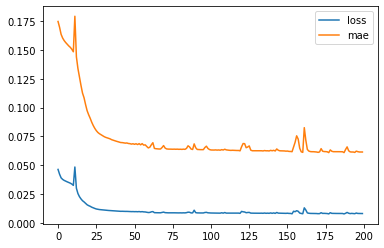

In [27]:
pd.DataFrame(history.history).plot()

Mean for 0 month = 33.46047161065776
Mean for 1 month = 32.85230748622418
Mean for 2 month = 32.34058753547091


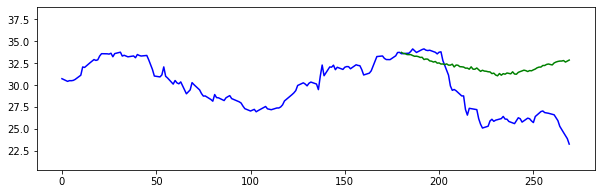

Mean for 0 month = 27.292668603180278
Mean for 1 month = 27.570640105331925
Mean for 2 month = 27.750914338150363


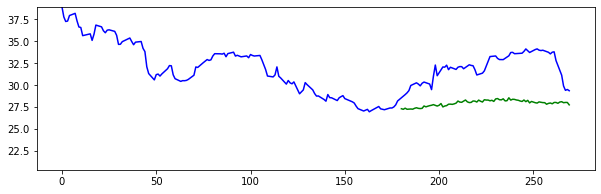

Mean for 0 month = 28.935092064771197
Mean for 1 month = 29.346379592414024
Mean for 2 month = 29.590583215662445


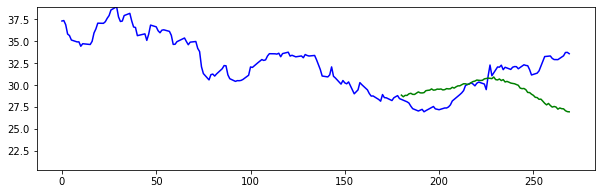

Mean for 0 month = 26.25956402843669
Mean for 1 month = 26.643899966105835
Mean for 2 month = 27.05821208855257


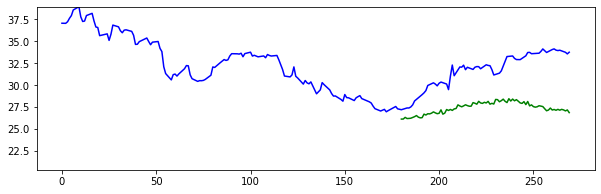

Mean for 0 month = 27.08691822367053
Mean for 1 month = 27.56977456159724
Mean for 2 month = 27.881963751906557


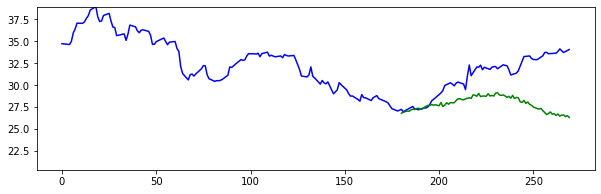

Mean for 0 month = 33.35317587209415
Mean for 1 month = 32.80468418155021
Mean for 2 month = 32.54248073947815


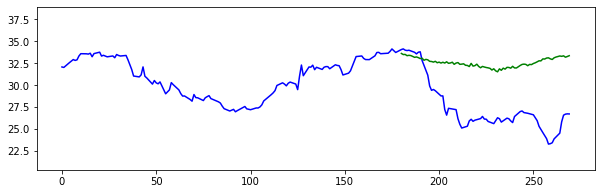

Mean for 0 month = 31.57556938755416
Mean for 1 month = 30.970640421129605
Mean for 2 month = 30.291723724559983


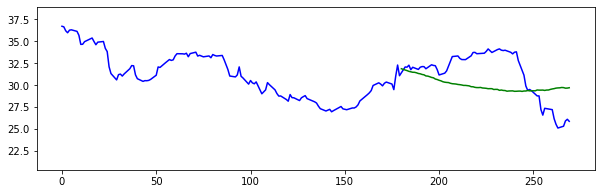

Mean for 0 month = 30.2106077517612
Mean for 1 month = 29.750101352855218
Mean for 2 month = 29.282798843067077


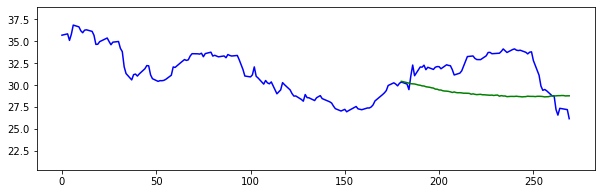

Mean for 0 month = 33.367479272751396
Mean for 1 month = 32.77453195303698
Mean for 2 month = 32.32625189440739


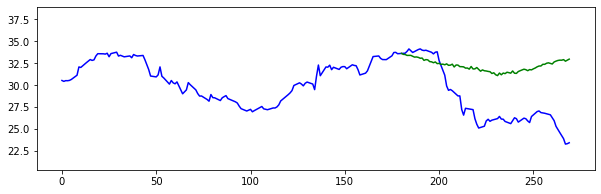

Mean for 0 month = 33.29617450027753
Mean for 1 month = 32.637959590925064
Mean for 2 month = 31.944938383652765


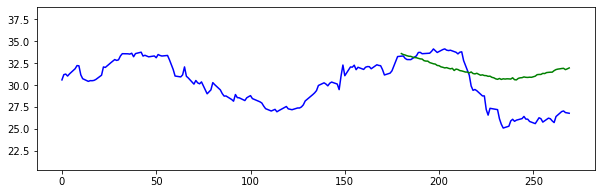

Mean for 0 month = 33.353093158775984
Mean for 1 month = 32.69619132334945
Mean for 2 month = 32.02031845465368


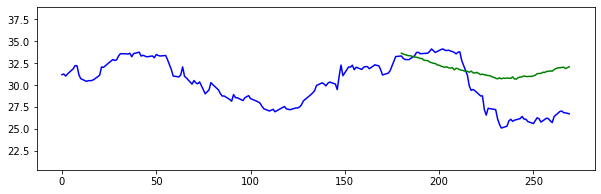

Mean for 0 month = 31.613106225537898
Mean for 1 month = 31.06621021275698
Mean for 2 month = 30.65047639956731


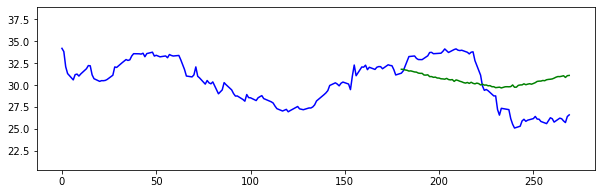

Mean for 0 month = 26.65913639300331
Mean for 1 month = 27.14826176675649
Mean for 2 month = 27.525477077178238


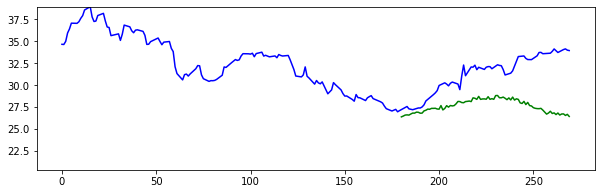

Mean for 0 month = 32.20417993295244
Mean for 1 month = 31.558864187803202
Mean for 2 month = 30.871183437069732


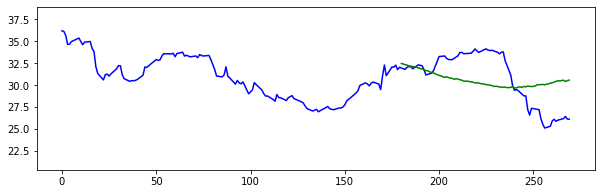

Mean for 0 month = 31.829225786748758
Mean for 1 month = 31.264785211915573
Mean for 2 month = 30.79710899134916


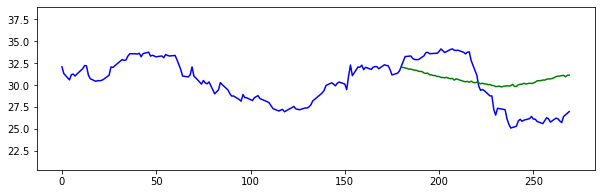

Mean for 0 month = 32.18549750690627
Mean for 1 month = 31.536426087947383
Mean for 2 month = 30.836717886892092


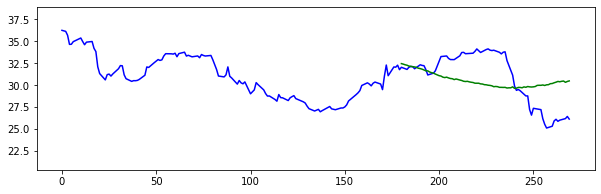

Mean for 0 month = 28.87132437665476
Mean for 1 month = 29.207469967607846
Mean for 2 month = 29.282774440414745


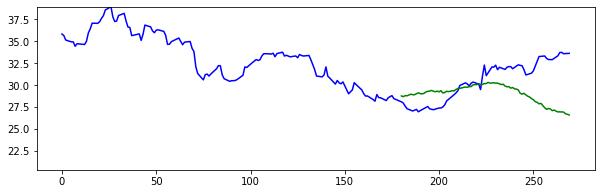

Mean for 0 month = 26.603687507922665
Mean for 1 month = 26.99718238914562
Mean for 2 month = 27.347456004063208


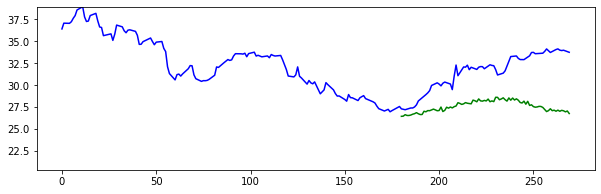

Mean for 0 month = 33.369920427375526
Mean for 1 month = 32.81206223176566
Mean for 2 month = 32.50776682699837


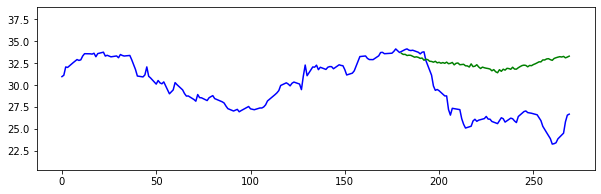

Mean for 0 month = 32.72969210716275
Mean for 1 month = 32.255953244956956
Mean for 2 month = 32.40860645467623


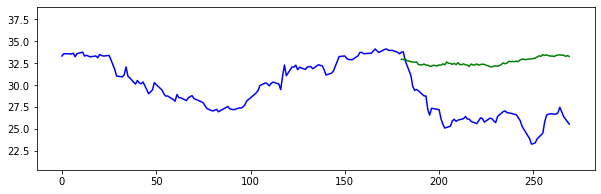

Mean for 0 month = 32.189367467397496
Mean for 1 month = 31.548373937817843
Mean for 2 month = 30.8790759996998


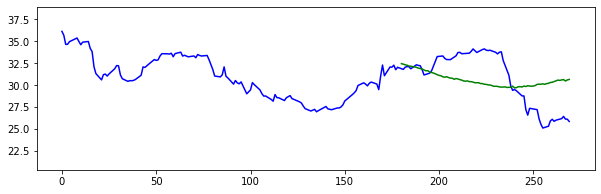

Mean for 0 month = 33.44420121169626
Mean for 1 month = 32.899386595074965
Mean for 2 month = 32.66651636402291


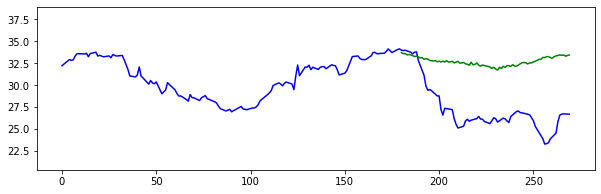

Mean for 0 month = 28.083270291693395
Mean for 1 month = 28.222688870223465
Mean for 2 month = 28.22282872688241


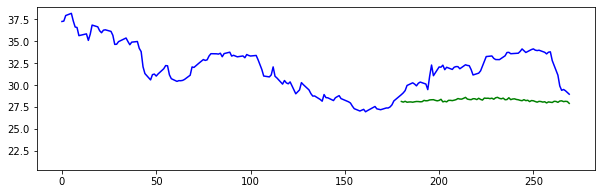

Mean for 0 month = 30.10409879028453
Mean for 1 month = 29.656464040062616
Mean for 2 month = 29.20395031580689


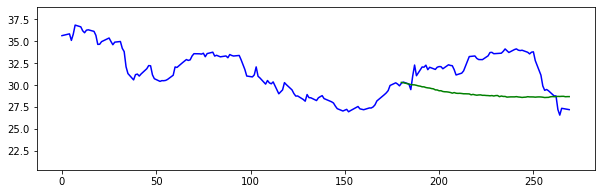

Mean for 0 month = 32.224630245000654
Mean for 1 month = 31.601238087292607
Mean for 2 month = 31.0008851462567


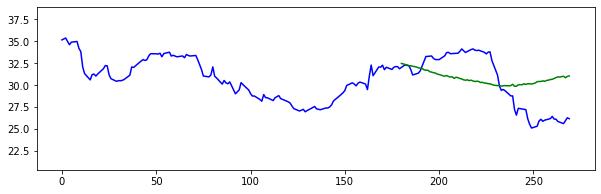

Mean for 0 month = 28.018729445282315
Mean for 1 month = 28.39913961320525
Mean for 2 month = 29.600800200411168


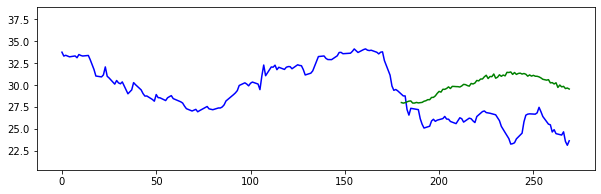

Mean for 0 month = 33.32952531061474
Mean for 1 month = 32.77797422786288
Mean for 2 month = 32.50078878016838


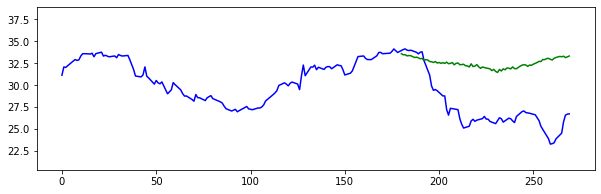

Mean for 0 month = 32.93493697933687
Mean for 1 month = 32.328083038310034
Mean for 2 month = 31.83233220548032


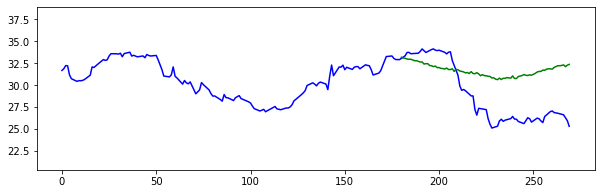

Mean for 0 month = 30.40382850882794
Mean for 1 month = 29.918758589075868
Mean for 2 month = 29.427282556183762


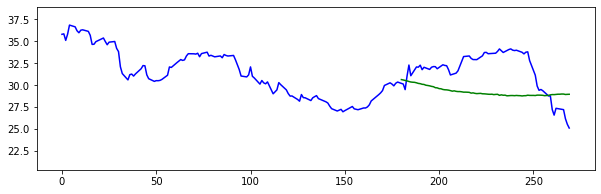

Mean for 0 month = 28.189467744141147
Mean for 1 month = 28.48870724174845
Mean for 2 month = 29.693772249096348


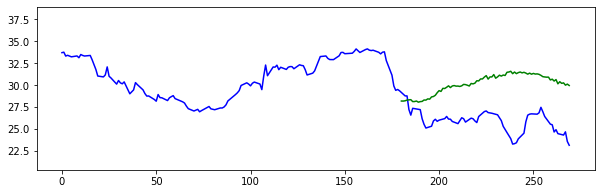

Mean for 0 month = 26.94565988526718
Mean for 1 month = 27.584714209996257
Mean for 2 month = 28.59054973793817


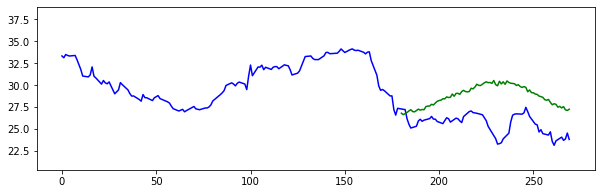

Mean for 0 month = 27.44780037751235
Mean for 1 month = 27.897345093871554
Mean for 2 month = 28.147810748996115


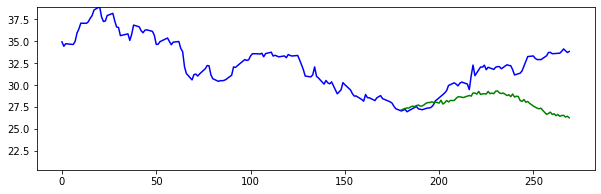

In [28]:
show_sample_predictions(model)

LSTM x2 + DENSE

In [29]:
def create_model_lstm_x2_dense():
  model = Sequential([
                      LSTM(36, input_shape=(WINDOW_SIZE, 1), return_sequences=True),
                      LSTM(10, return_sequences=False),
                      Dense(STEPS_AHEAD,  name='output', activation='sigmoid')])

  model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(), metrics=['mae'])
  return model 

model = create_model_lstm_x2_dense()
callback = tf.keras.callbacks.EarlyStopping(monitor='loss',  patience=30, restore_best_weights=True)
history = model.fit(ds_train, epochs=200, verbose=1,  callbacks=[callback])

Epoch 1/200
117/117 [==============================] - 4s 13ms/step - loss: 0.0510 - mae: 0.1843
Epoch 2/200
117/117 [==============================] - 1s 12ms/step - loss: 0.0411 - mae: 0.1661
Epoch 3/200
117/117 [==============================] - 1s 12ms/step - loss: 0.0385 - mae: 0.1609
Epoch 4/200
117/117 [==============================] - 2s 13ms/step - loss: 0.0373 - mae: 0.1578
Epoch 5/200
117/117 [==============================] - 1s 12ms/step - loss: 0.0368 - mae: 0.1565
Epoch 6/200
117/117 [==============================] - 2s 13ms/step - loss: 0.0365 - mae: 0.1557
Epoch 7/200
117/117 [==============================] - 2s 13ms/step - loss: 0.0363 - mae: 0.1551
Epoch 8/200
117/117 [==============================] - 1s 12ms/step - loss: 0.0361 - mae: 0.1547
Epoch 9/200
117/117 [==============================] - 1s 12ms/step - loss: 0.0360 - mae: 0.1544
Epoch 10/200
117/117 [==============================] - 2s 13ms/step - loss: 0.0359 - mae: 0.1540
Epoch 11/200
117/117 [=======

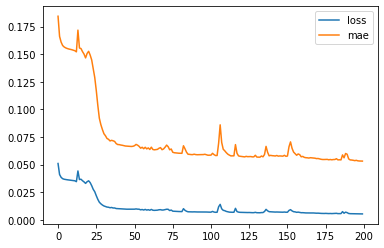

In [30]:
pd.DataFrame(history.history).plot()

Mean for 0 month = 27.454990154872526
Mean for 1 month = 29.03510263884158
Mean for 2 month = 30.521245177964328


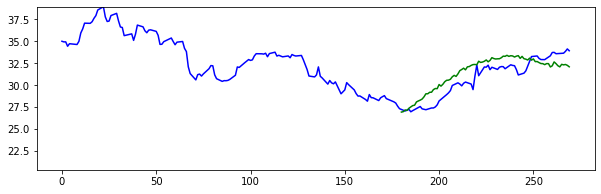

Mean for 0 month = 27.59438961150646
Mean for 1 month = 27.6768135442357
Mean for 2 month = 27.785542313271343


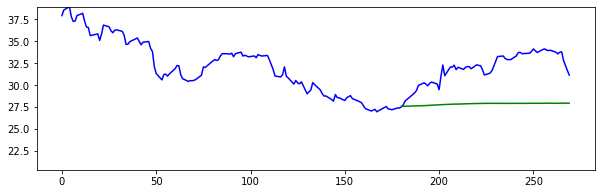

Mean for 0 month = 30.454266845665007
Mean for 1 month = 29.86713102594249
Mean for 2 month = 29.1754663615577


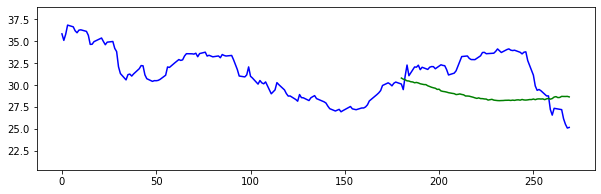

Mean for 0 month = 28.439836955981423
Mean for 1 month = 28.334269025259648
Mean for 2 month = 28.232834147861684


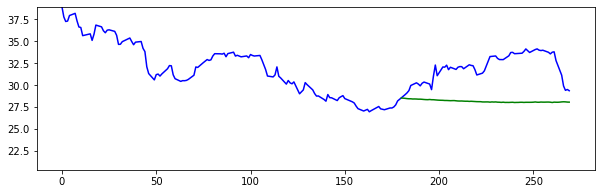

Mean for 0 month = 32.45665766736313
Mean for 1 month = 32.37453946262444
Mean for 2 month = 32.66018012362544


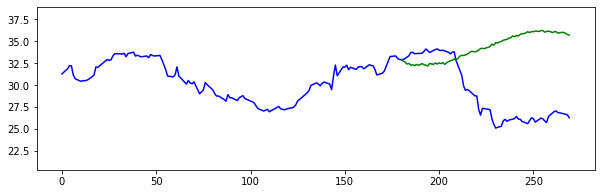

Mean for 0 month = 30.86850614926309
Mean for 1 month = 30.13329636925057
Mean for 2 month = 30.19950148766834


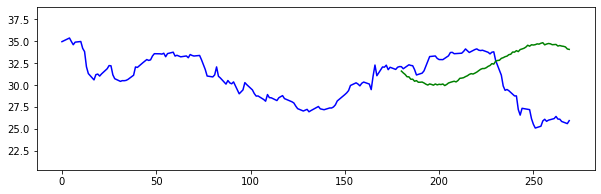

Mean for 0 month = 32.96370564972562
Mean for 1 month = 32.76131983454526
Mean for 2 month = 32.918042005884146


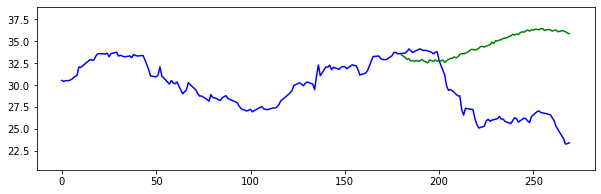

Mean for 0 month = 27.951697304856662
Mean for 1 month = 28.524467244238053
Mean for 2 month = 28.775231234294484


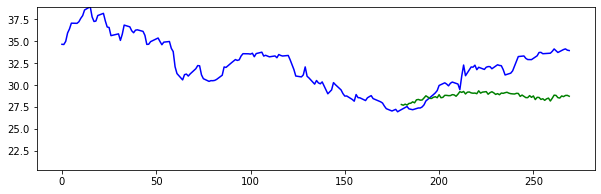

Mean for 0 month = 31.378990069544024
Mean for 1 month = 30.927204811709395
Mean for 2 month = 31.03929970150785


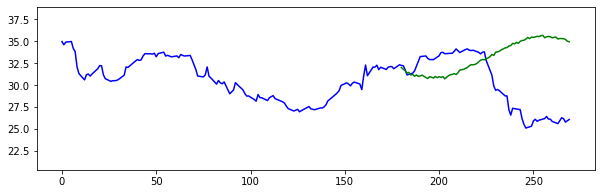

Mean for 0 month = 27.31697314462492
Mean for 1 month = 28.81682847351409
Mean for 2 month = 30.199039504881178


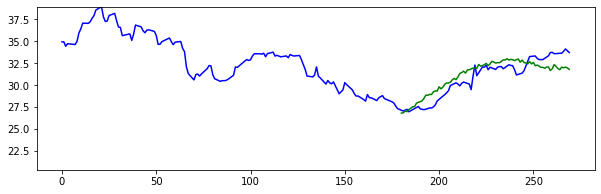

Mean for 0 month = 30.581070253501622
Mean for 1 month = 29.9589149600695
Mean for 2 month = 29.2396281608474


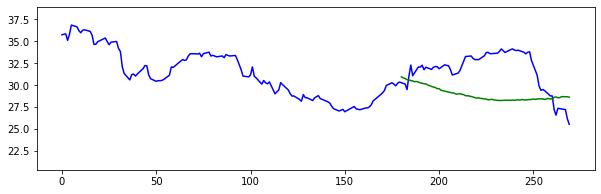

Mean for 0 month = 33.40178506615725
Mean for 1 month = 33.04098190131079
Mean for 2 month = 33.00398403398093


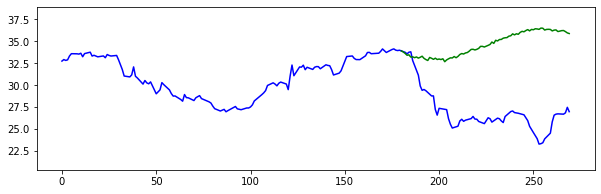

Mean for 0 month = 27.044078950592603
Mean for 1 month = 29.169237515065255
Mean for 2 month = 30.952646605691957


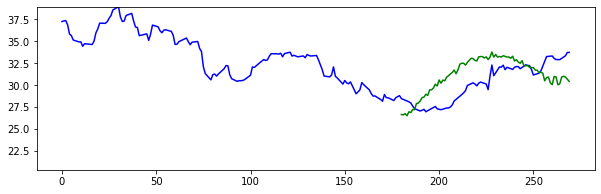

Mean for 0 month = 30.227640691918015
Mean for 1 month = 29.737178175108017
Mean for 2 month = 29.142663471366443


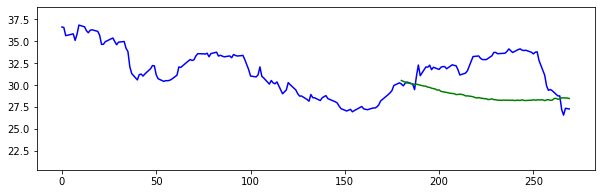

Mean for 0 month = 30.169606181840976
Mean for 1 month = 29.641660690760478
Mean for 2 month = 29.021437320294062


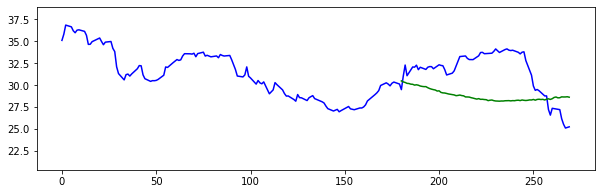

Mean for 0 month = 30.778363307402408
Mean for 1 month = 30.162565655327104
Mean for 2 month = 30.28574690910557


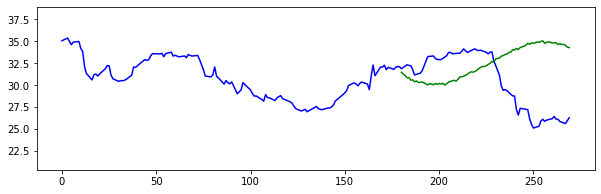

Mean for 0 month = 30.296589246562224
Mean for 1 month = 29.74633456166409
Mean for 2 month = 29.10755794912423


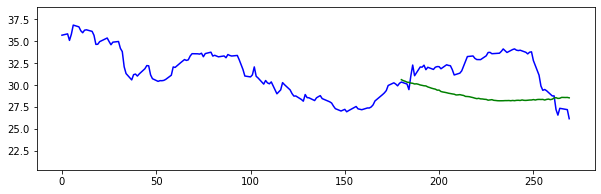

Mean for 0 month = 31.51829374993656
Mean for 1 month = 30.213158301419043
Mean for 2 month = 29.8116825299702


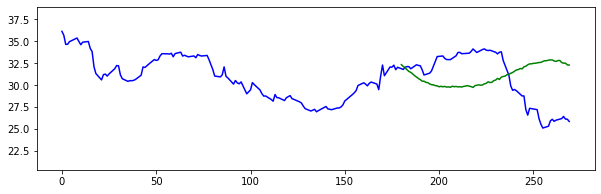

Mean for 0 month = 27.467567470882063
Mean for 1 month = 27.60244420997152
Mean for 2 month = 27.757347855635743


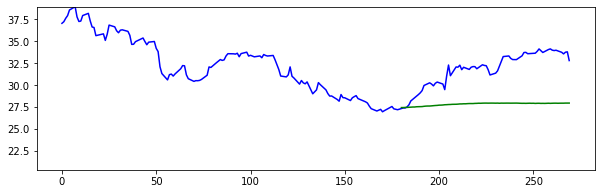

Mean for 0 month = 28.73702268412206
Mean for 1 month = 28.57578552181882
Mean for 2 month = 28.398131878161507


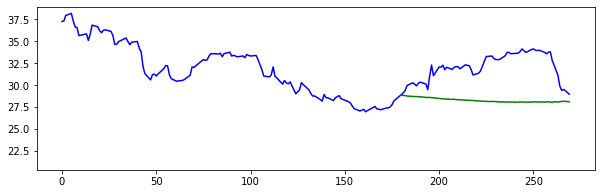

Mean for 0 month = 29.364971745322617
Mean for 1 month = 29.062200755903092
Mean for 2 month = 28.71565035204127


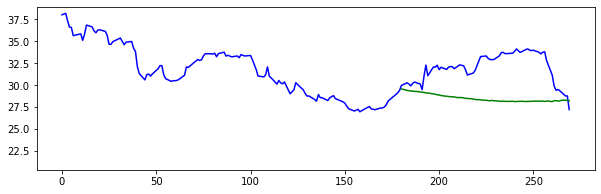

Mean for 0 month = 32.92175888003246
Mean for 1 month = 32.739305973966495
Mean for 2 month = 32.91969493816175


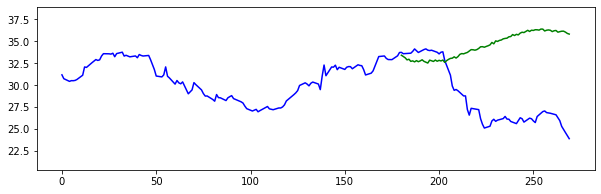

Mean for 0 month = 28.879144398370705
Mean for 1 month = 28.68735083515074
Mean for 2 month = 28.471767965530546


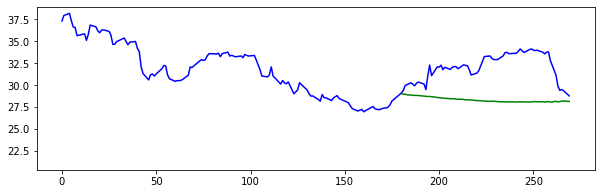

Mean for 0 month = 27.779882009667507
Mean for 1 month = 27.81575435329691
Mean for 2 month = 27.878020805805967


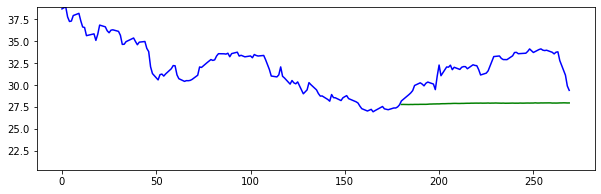

Mean for 0 month = 33.505945036102204
Mean for 1 month = 33.12709346947507
Mean for 2 month = 33.07276627259829


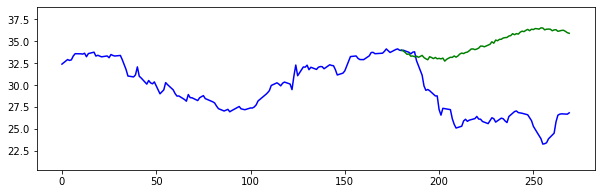

Mean for 0 month = 27.62040450650402
Mean for 1 month = 27.69392347225923
Mean for 2 month = 27.795618385209877


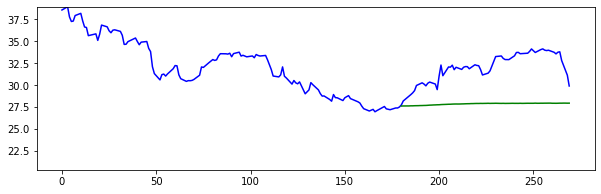

Mean for 0 month = 31.179566369483684
Mean for 1 month = 31.37551622135474
Mean for 2 month = 31.94481853828047


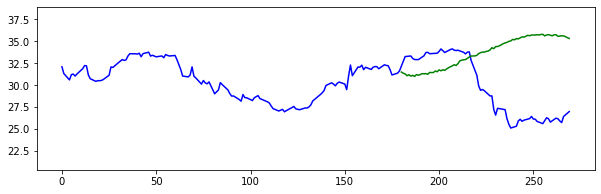

Mean for 0 month = 28.37238035393107
Mean for 1 month = 29.49762712041969
Mean for 2 month = 30.24966767100692


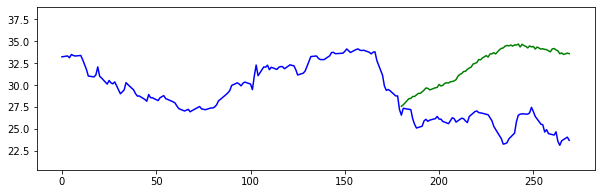

Mean for 0 month = 33.396340439754006
Mean for 1 month = 33.06544669980939
Mean for 2 month = 33.0747428318506


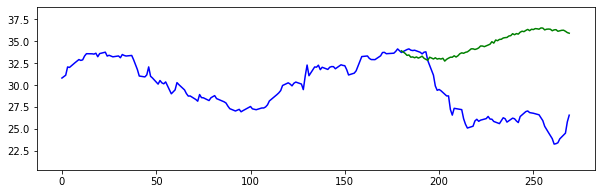

Mean for 0 month = 30.217830825678885
Mean for 1 month = 29.732073962925522
Mean for 2 month = 29.146143156181004


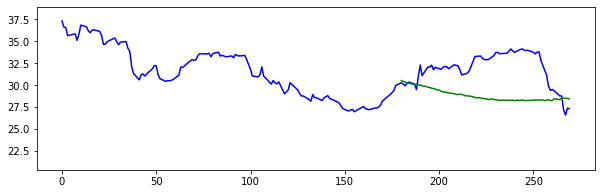

Mean for 0 month = 33.22213651956819
Mean for 1 month = 32.91991495114112
Mean for 2 month = 32.96227984555154


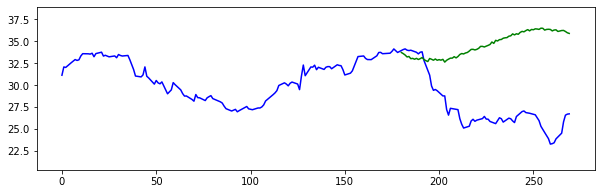

Mean for 0 month = 31.658843244097106
Mean for 1 month = 30.84420800031279
Mean for 2 month = 29.84742129826119


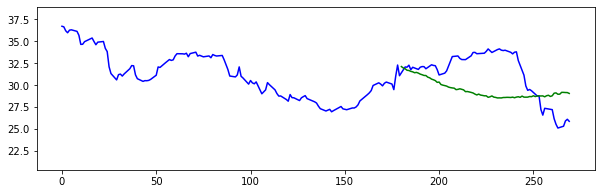

In [31]:
show_sample_predictions(model)

LSTM x2

In [32]:
def create_model_lstm_x2():
  model = Sequential([
                      LSTM(50, input_shape=(WINDOW_SIZE, 1), return_sequences=True),
                      LSTM(STEPS_AHEAD,  name='output', activation='sigmoid')])

  model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(), metrics=['mae'])
  return model 

model = create_model_lstm_x2()
callback = tf.keras.callbacks.EarlyStopping(monitor='loss',  patience=30, restore_best_weights=True)
history = model.fit(ds_train, epochs=200, verbose=1,  callbacks=[callback])

Epoch 1/200
117/117 [==============================] - 28s 220ms/step - loss: 0.0219 - mae: 0.1145
Epoch 2/200
117/117 [==============================] - 26s 219ms/step - loss: 0.0493 - mae: 0.1731
Epoch 3/200
117/117 [==============================] - 26s 219ms/step - loss: 0.0380 - mae: 0.1591
Epoch 4/200
117/117 [==============================] - 26s 219ms/step - loss: 0.0390 - mae: 0.1607
Epoch 5/200
117/117 [==============================] - 26s 219ms/step - loss: 0.0395 - mae: 0.1613
Epoch 6/200
117/117 [==============================] - 26s 221ms/step - loss: 0.0268 - mae: 0.1188
Epoch 7/200
117/117 [==============================] - 26s 218ms/step - loss: 0.0156 - mae: 0.0861
Epoch 8/200
117/117 [==============================] - 26s 218ms/step - loss: 0.0255 - mae: 0.1095
Epoch 9/200
117/117 [==============================] - 26s 219ms/step - loss: 0.0172 - mae: 0.0882
Epoch 10/200
117/117 [==============================] - 26s 218ms/step - loss: 0.0110 - mae: 0.0745
Epoch 11/

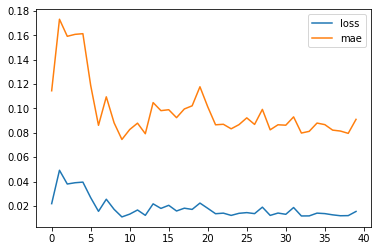

In [33]:
pd.DataFrame(history.history).plot()

Mean for 0 month = 31.422112557915007
Mean for 1 month = 31.918240103215982
Mean for 2 month = 32.04724063915337


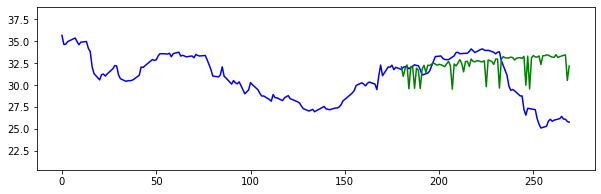

Mean for 0 month = 31.418072112378884
Mean for 1 month = 31.92236993249915
Mean for 2 month = 32.048063325382465


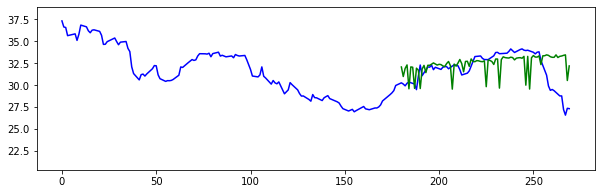

Mean for 0 month = 31.2826665750396
Mean for 1 month = 31.7600045783239
Mean for 2 month = 31.901951749683406


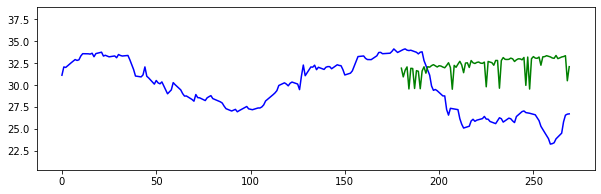

Mean for 0 month = 31.370228294443383
Mean for 1 month = 31.861152905214375
Mean for 2 month = 31.993582430706795


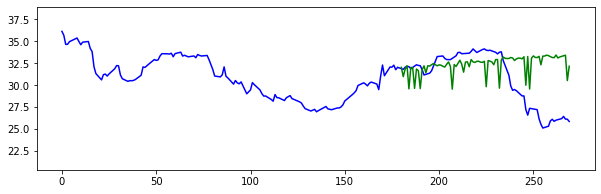

Mean for 0 month = 30.976200112431105
Mean for 1 month = 31.4285619732559
Mean for 2 month = 31.590161006326127


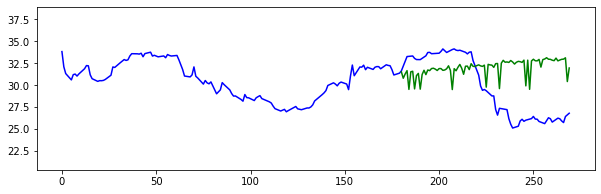

Mean for 0 month = 31.659234909446447
Mean for 1 month = 32.195761184657194
Mean for 2 month = 32.308781874397916


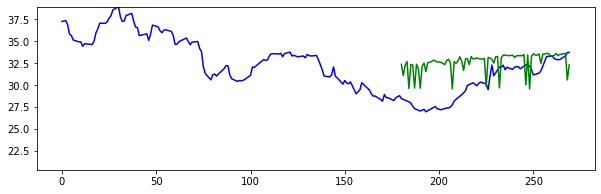

Mean for 0 month = 31.127258422604076
Mean for 1 month = 31.591132165184813
Mean for 2 month = 31.744590328909737


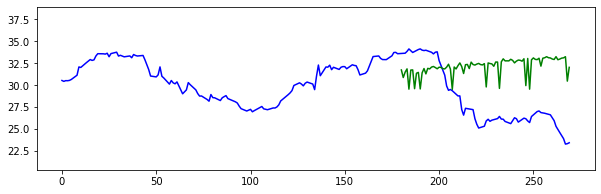

Mean for 0 month = 31.454784040657227
Mean for 1 month = 31.97058829501653
Mean for 2 month = 32.091546350434655


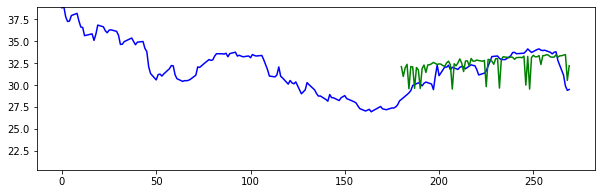

Mean for 0 month = 31.363609950490996
Mean for 1 month = 31.84821377402475
Mean for 2 month = 31.98467724138513


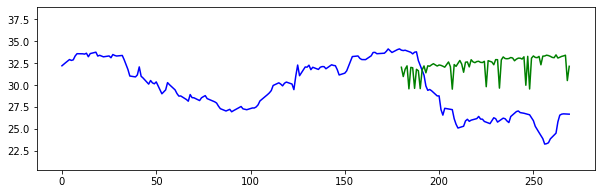

Mean for 0 month = 31.16615185906223
Mean for 1 month = 31.63425948961673
Mean for 2 month = 31.7848056776121


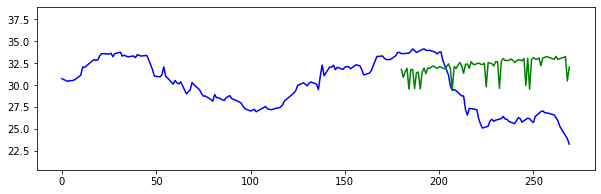

Mean for 0 month = 31.287484459062227
Mean for 1 month = 31.77162046318354
Mean for 2 month = 31.909637751365683


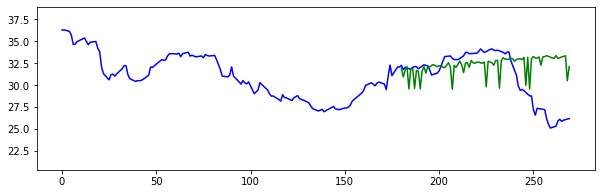

Mean for 0 month = 31.143288852886446
Mean for 1 month = 31.608782731469443
Mean for 2 month = 31.760966732103594


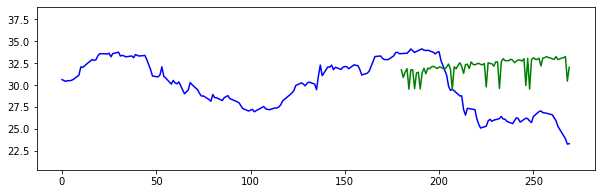

Mean for 0 month = 31.3648624902748
Mean for 1 month = 31.867283751989113
Mean for 2 month = 31.993849692557433


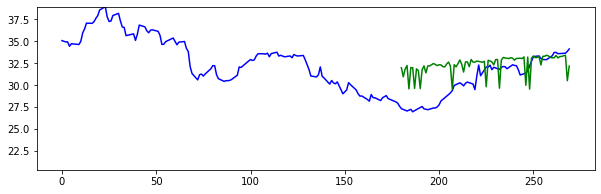

Mean for 0 month = 31.546049626873003
Mean for 1 month = 32.061900018365414
Mean for 2 month = 32.181276959790274


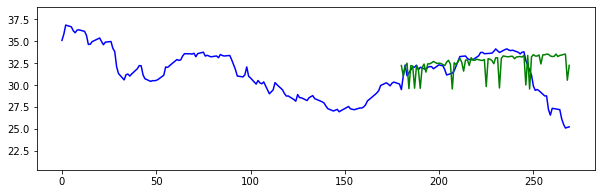

Mean for 0 month = 31.42730626501837
Mean for 1 month = 31.936761493991487
Mean for 2 month = 32.05985169641568


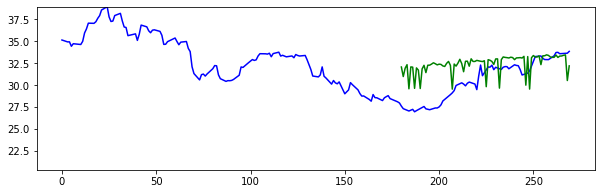

Mean for 0 month = 31.25992007902168
Mean for 1 month = 31.751454700514167
Mean for 2 month = 31.884602520023634


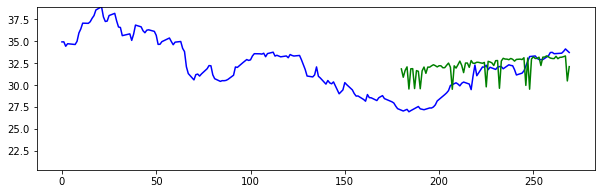

Mean for 0 month = 31.481244297956657
Mean for 1 month = 31.983374117515616
Mean for 2 month = 32.10912843364942


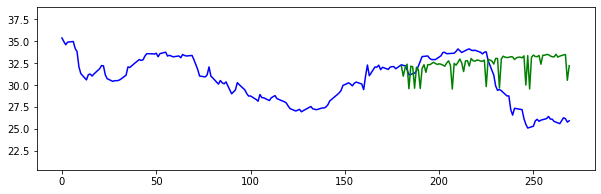

Mean for 0 month = 31.364065318436182
Mean for 1 month = 31.85115515522832
Mean for 2 month = 31.98548869905894


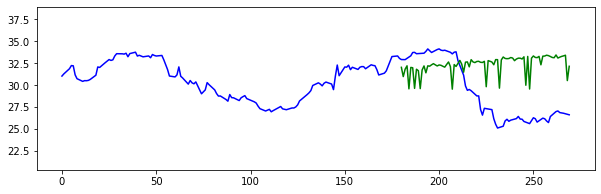

Mean for 0 month = 31.418257383541153
Mean for 1 month = 31.92746080382388
Mean for 2 month = 32.05112977712762


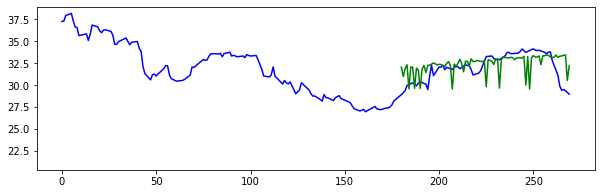

Mean for 0 month = 31.221196127044106
Mean for 1 month = 31.69417100279499
Mean for 2 month = 31.83753992048434


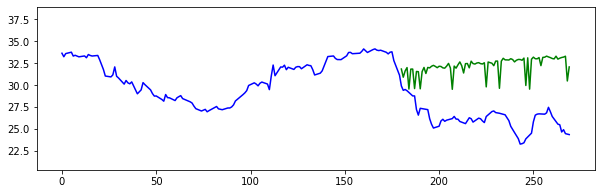

Mean for 0 month = 31.4099094529659
Mean for 1 month = 31.917424865632473
Mean for 2 month = 32.04187133300962


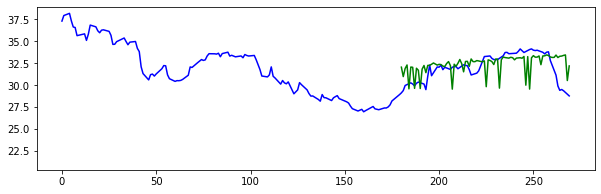

Mean for 0 month = 31.51794344124631
Mean for 1 month = 32.037532774889264
Mean for 2 month = 32.15592293753445


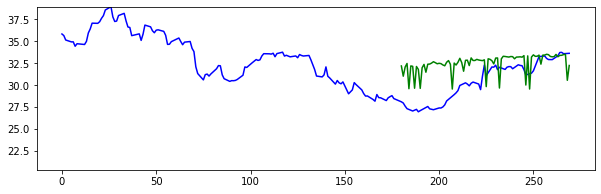

Mean for 0 month = 31.298282716101333
Mean for 1 month = 31.784261815310373
Mean for 2 month = 31.9213583063719


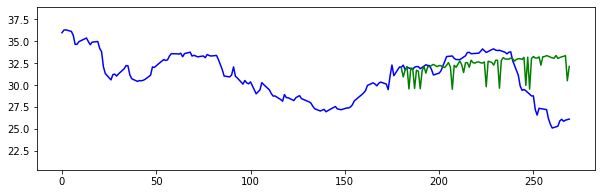

Mean for 0 month = 31.54024390791947
Mean for 1 month = 32.04875393711965
Mean for 2 month = 32.17116770246803


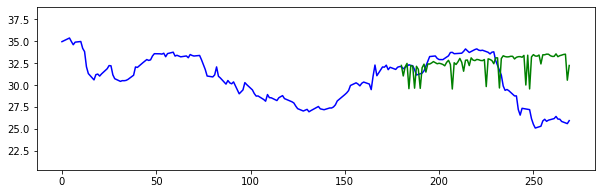

Mean for 0 month = 31.33586241159066
Mean for 1 month = 31.823723016440407
Mean for 2 month = 31.958479076353967


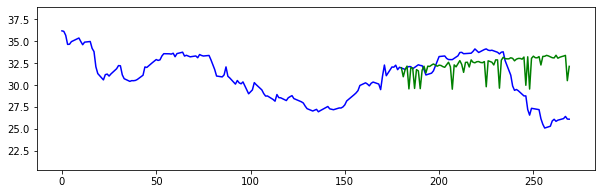

Mean for 0 month = 31.51011213538816
Mean for 1 month = 32.02303632090271
Mean for 2 month = 32.14363272790148


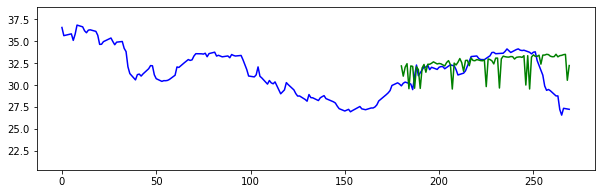

Mean for 0 month = 31.381521219371194
Mean for 1 month = 31.884493402924466
Mean for 2 month = 32.01141748993699


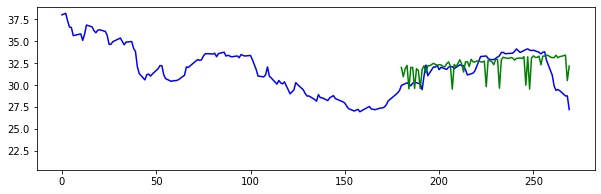

Mean for 0 month = 31.465562397583504
Mean for 1 month = 31.974277764819504
Mean for 2 month = 32.09731432587808


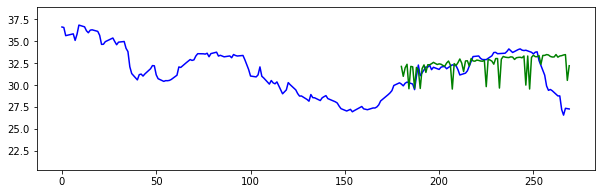

Mean for 0 month = 31.291661981911925
Mean for 1 month = 31.769767195691777
Mean for 2 month = 31.909312734718277


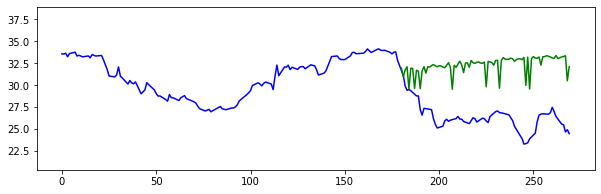

Mean for 0 month = 31.49516498275664
Mean for 1 month = 32.01621230539305
Mean for 2 month = 32.134608304663516


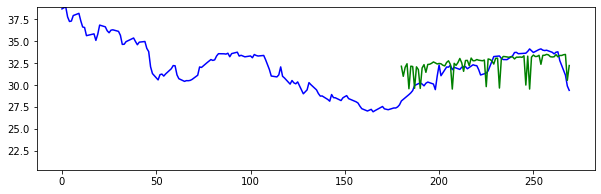

Mean for 0 month = 31.489189001105842
Mean for 1 month = 31.99853072161411
Mean for 2 month = 32.1203963444689


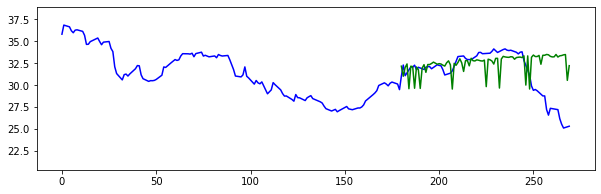

Mean for 0 month = 31.537729712099054
Mean for 1 month = 32.064214935122905
Mean for 2 month = 32.180352827455216


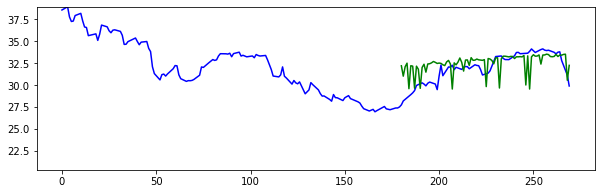

In [34]:
show_sample_predictions(model)

LSTM x3

In [35]:
def create_model_lstm_x3():
  model = Sequential([
                      LSTM(50, input_shape=(WINDOW_SIZE, 1), return_sequences=True),
                      LSTM(50, return_sequences=True),
                      LSTM(STEPS_AHEAD,  name='output', activation='sigmoid')])

  model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(), metrics=['mae'])
  return model 

model = create_model_lstm_x3()
callback = tf.keras.callbacks.EarlyStopping(monitor='loss',  patience=30, restore_best_weights=True)
history = model.fit(ds_train, epochs=200, verbose=1,  callbacks=[callback]) 


Epoch 1/200
117/117 [==============================] - 30s 227ms/step - loss: 0.0210 - mae: 0.1080
Epoch 2/200
117/117 [==============================] - 27s 228ms/step - loss: 0.0384 - mae: 0.1496
Epoch 3/200
117/117 [==============================] - 27s 228ms/step - loss: 0.0353 - mae: 0.1394
Epoch 4/200
117/117 [==============================] - 27s 228ms/step - loss: 0.0211 - mae: 0.1064
Epoch 5/200
117/117 [==============================] - 27s 228ms/step - loss: 0.0226 - mae: 0.1067
Epoch 6/200
117/117 [==============================] - 27s 228ms/step - loss: 0.0267 - mae: 0.1215
Epoch 7/200
117/117 [==============================] - 27s 229ms/step - loss: 0.0182 - mae: 0.0955
Epoch 8/200
117/117 [==============================] - 27s 229ms/step - loss: 0.0247 - mae: 0.1185
Epoch 9/200
117/117 [==============================] - 27s 229ms/step - loss: 0.0209 - mae: 0.1113
Epoch 10/200
117/117 [==============================] - 27s 227ms/step - loss: 0.0191 - mae: 0.1082
Epoch 11/

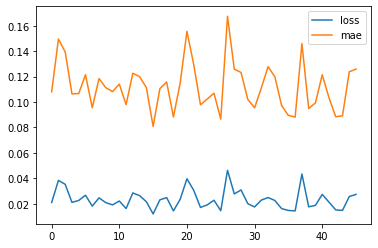

In [36]:
pd.DataFrame(history.history).plot()

Mean for 0 month = 31.598337451292146
Mean for 1 month = 31.393431770426808
Mean for 2 month = 31.426343277435063


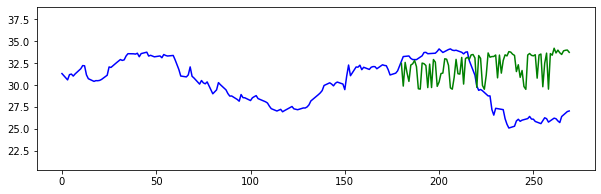

Mean for 0 month = 31.527264642982736
Mean for 1 month = 31.32990766413847
Mean for 2 month = 31.369003047831104


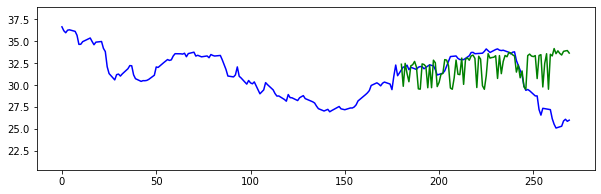

Mean for 0 month = 31.52163402278743
Mean for 1 month = 31.32469450161753
Mean for 2 month = 31.36407871488086


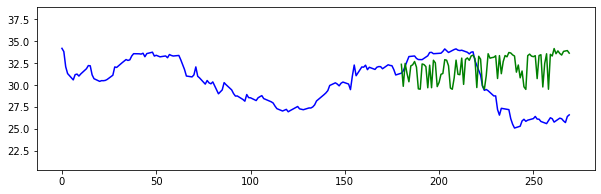

Mean for 0 month = 31.5112684542353
Mean for 1 month = 31.314705423189025
Mean for 2 month = 31.356402663255


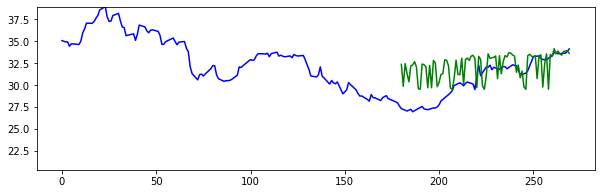

Mean for 0 month = 31.61698024387335
Mean for 1 month = 31.410547145967257
Mean for 2 month = 31.441474144795443


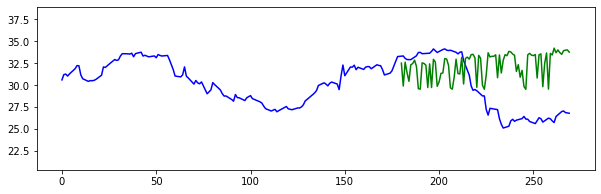

Mean for 0 month = 31.52046036082519
Mean for 1 month = 31.32334496268036
Mean for 2 month = 31.363555308561047


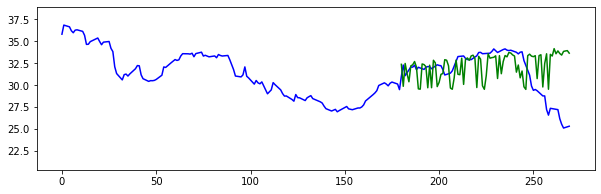

Mean for 0 month = 31.526339565670252
Mean for 1 month = 31.329154072435237
Mean for 2 month = 31.36815946092483


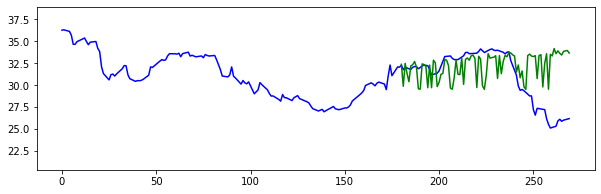

Mean for 0 month = 31.54632505999903
Mean for 1 month = 31.345681116148064
Mean for 2 month = 31.384918357628305


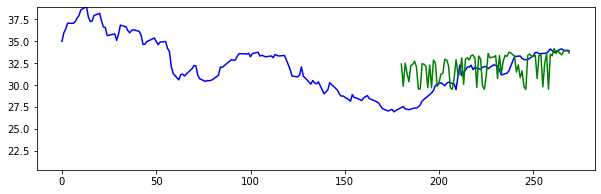

Mean for 0 month = 31.5427468195977
Mean for 1 month = 31.343380596399584
Mean for 2 month = 31.381724778625987


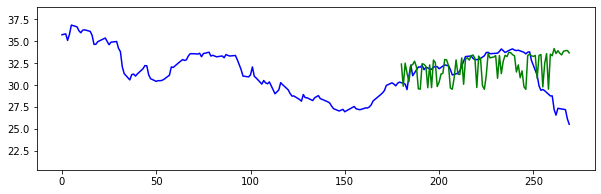

Mean for 0 month = 31.536604577506942
Mean for 1 month = 31.338303566214798
Mean for 2 month = 31.376507558260812


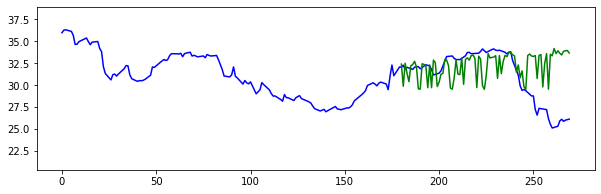

Mean for 0 month = 31.59781337792944
Mean for 1 month = 31.393455228101722
Mean for 2 month = 31.425557334151733


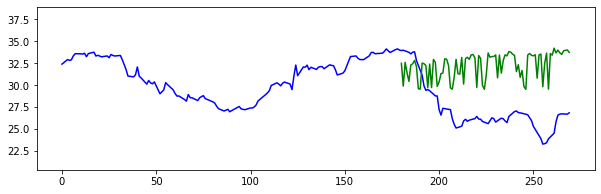

Mean for 0 month = 31.52256415850848
Mean for 1 month = 31.325774277293227
Mean for 2 month = 31.36487049478946


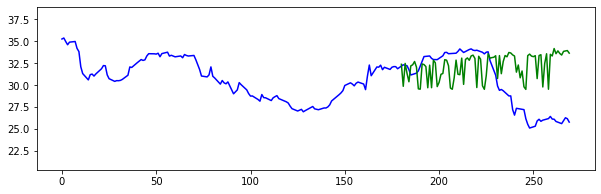

Mean for 0 month = 31.506575140472098
Mean for 1 month = 31.310884101241765
Mean for 2 month = 31.352831537977817


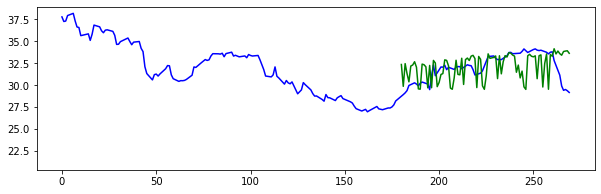

Mean for 0 month = 31.525689532375452
Mean for 1 month = 31.32733109980798
Mean for 2 month = 31.36810092791136


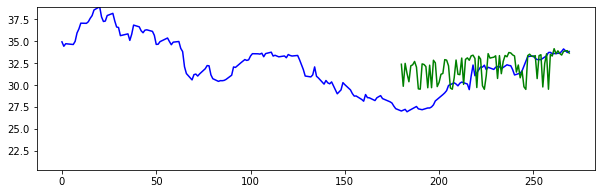

Mean for 0 month = 31.552593706717147
Mean for 1 month = 31.35244315225601
Mean for 2 month = 31.389274647972115


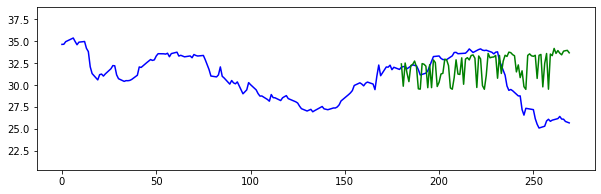

Mean for 0 month = 31.593397442834025
Mean for 1 month = 31.38947381586123
Mean for 2 month = 31.421958193073237


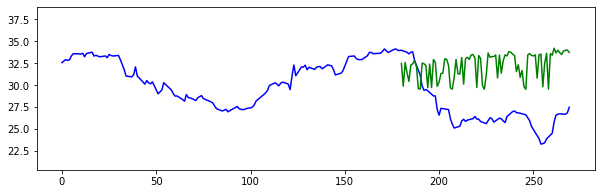

Mean for 0 month = 31.624360906673445
Mean for 1 month = 31.417373829648483
Mean for 2 month = 31.447249846818984


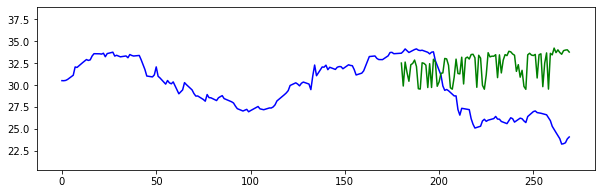

Mean for 0 month = 31.48434977171079
Mean for 1 month = 31.290982543143116
Mean for 2 month = 31.33491348749492


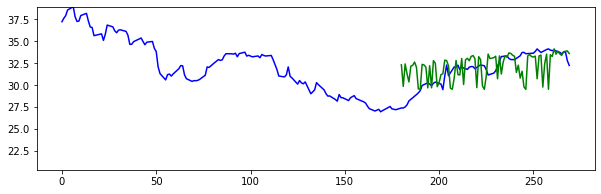

Mean for 0 month = 31.49161459139591
Mean for 1 month = 31.297311612829553
Mean for 2 month = 31.34073866186602


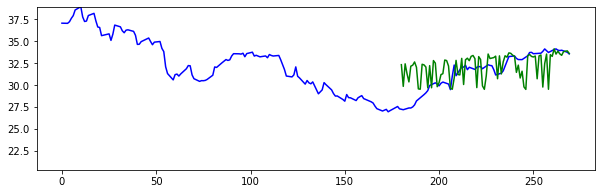

Mean for 0 month = 31.627452539287628
Mean for 1 month = 31.420164236811633
Mean for 2 month = 31.449753036431748


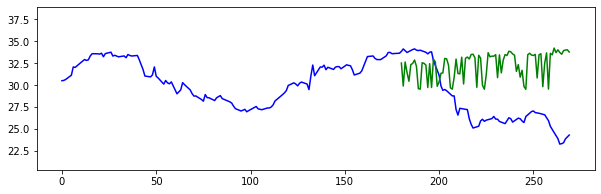

Mean for 0 month = 31.578145284841764
Mean for 1 month = 31.375695266783385
Mean for 2 month = 31.409535797774538


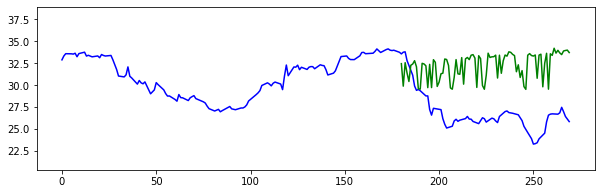

Mean for 0 month = 31.57414953117916
Mean for 1 month = 31.370435411260253
Mean for 2 month = 31.407400927010023


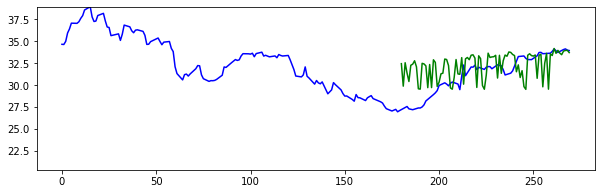

Mean for 0 month = 31.434797823698666
Mean for 1 month = 31.24787734230033
Mean for 2 month = 31.294663063454017


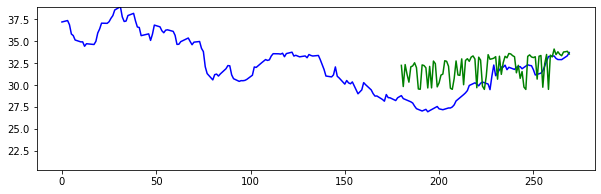

Mean for 0 month = 31.50585367800132
Mean for 1 month = 31.310654916422674
Mean for 2 month = 31.351974276692335


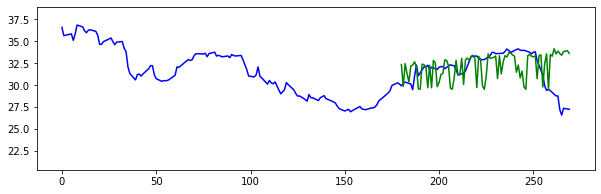

Mean for 0 month = 31.54077759781715
Mean for 1 month = 31.341954958986225
Mean for 2 month = 31.37972448376422


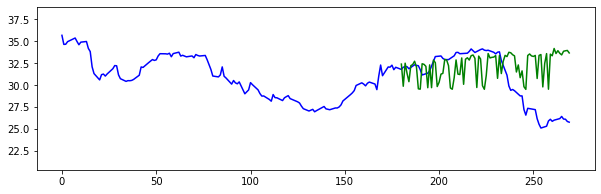

Mean for 0 month = 31.612108162616046
Mean for 1 month = 31.406189632711495
Mean for 2 month = 31.437493844293094


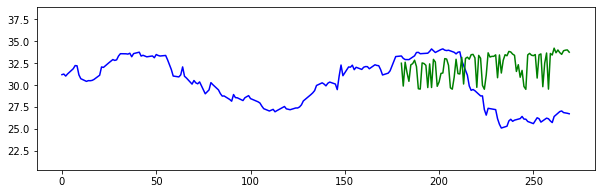

Mean for 0 month = 31.63442308188514
Mean for 1 month = 31.42658430226543
Mean for 2 month = 31.45541156125455


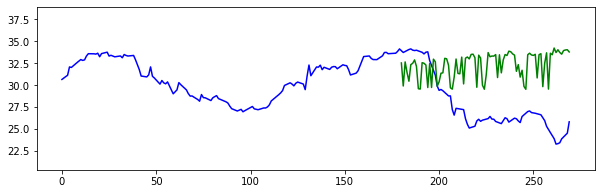

Mean for 0 month = 31.587136745043665
Mean for 1 month = 31.383814901930066
Mean for 2 month = 31.416852146522796


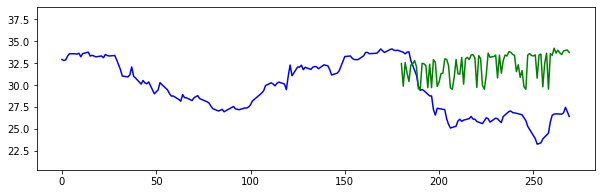

Mean for 0 month = 31.594468269017632
Mean for 1 month = 31.390308508862326
Mean for 2 month = 31.423039191660894


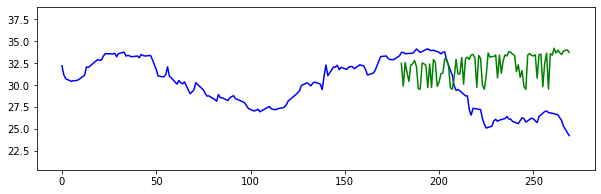

Mean for 0 month = 31.606713119734177
Mean for 1 month = 31.401121218497348
Mean for 2 month = 31.43315511941201


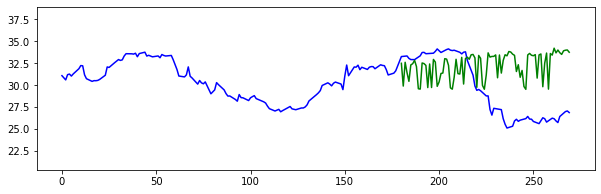

Mean for 0 month = 31.440334502020505
Mean for 1 month = 31.25256620911095
Mean for 2 month = 31.299442870445084


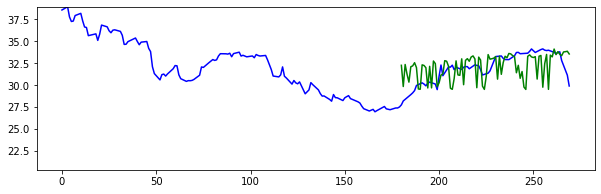

Mean for 0 month = 31.560508226175624
Mean for 1 month = 31.358730976457167
Mean for 2 month = 31.395392042715276


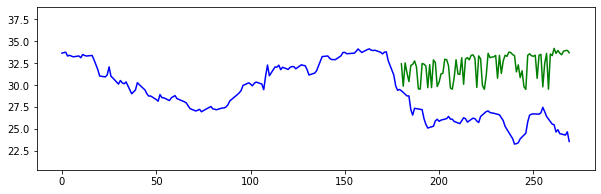

In [37]:
show_sample_predictions(model)

#GRU Models

In [ ]:
	# GRU + Dense
	# GRU x2 + Dense
	# GRU x2
	# GRU x3

GRU x2

In [46]:
from tensorflow.keras.optimizers import SGD
regressorGRU = Sequential()
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(WINDOW_SIZE, 1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
regressorGRU.add(GRU(STEPS_AHEAD))

regressorGRU.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error', metrics=['mae'])
history = regressorGRU.fit(ds_train,epochs=200,verbose=1,  callbacks=[callback])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/200
117/117 [==============================] - 5s 21ms/step - loss: 0.1023 - mae: 0.2776
Epoch 2/200
117/117 [==============================] - 2s 21ms/step - loss: 0.0401 - mae: 0.1489
Epoch 3/200
117/117 [==============================] - 2s 21ms/step - loss: 0.0314 - mae: 0.1415
Epoch 4/200
117/117 [==============================] - 2s 21ms/step - loss: 0.0307 - mae: 0.1419
Epoch 5/200
117/117 [==============================] - 2s 21ms/step - loss: 0.0294 - mae: 0.1390
Epoch 6/200
117/117 [==============================] - 2s 21ms/step - loss: 0.0282 - mae: 0.1359
Epoch 7/200
117/117 [==============================] - 2s 21ms/step - loss: 0.0269 - mae: 0.1321
Epoch 8/200
117/117 [==============================] - 2s 21ms/step - loss: 0.0255 - mae: 0.1281
Epoch 9/200
117/117 [==============================] - 2s 21ms/step - loss: 0.0240 - mae: 0.1233
Epoch 10/200
117/117 [==============================] - 2s 21ms/step - loss: 0.0224 - mae: 0.1181
Epoch 11/200
117/117 [=======

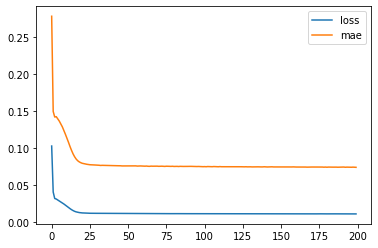

In [47]:
pd.DataFrame(history.history).plot()

Mean for 0 month = 31.156818761727614
Mean for 1 month = 30.953733218557254
Mean for 2 month = 30.776982973318553


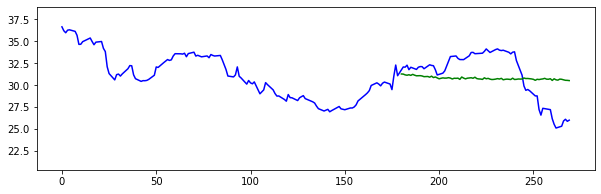

Mean for 0 month = 31.61218048118253
Mean for 1 month = 31.385293513666152
Mean for 2 month = 31.26229969893935


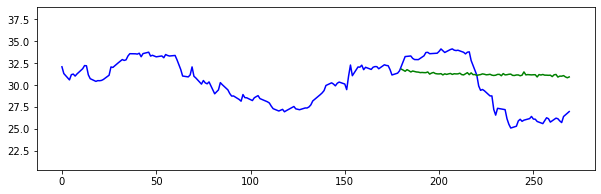

Mean for 0 month = 31.997228765069643
Mean for 1 month = 31.761489804901963
Mean for 2 month = 31.589325924216684


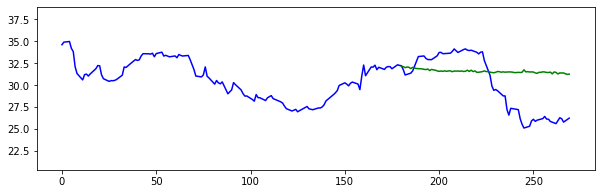

Mean for 0 month = 31.780227261986425
Mean for 1 month = 31.541483718301492
Mean for 2 month = 31.427233724104248


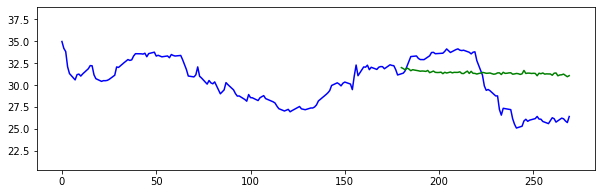

Mean for 0 month = 28.667575848440173
Mean for 1 month = 28.576607707765753
Mean for 2 month = 28.505344236364056


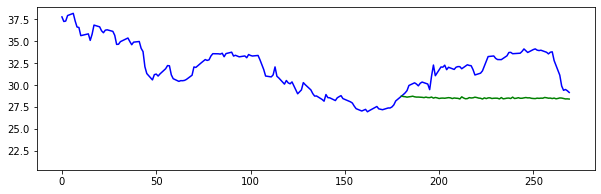

Mean for 0 month = 28.105137903118862
Mean for 1 month = 28.032290093683258
Mean for 2 month = 28.037438775391657


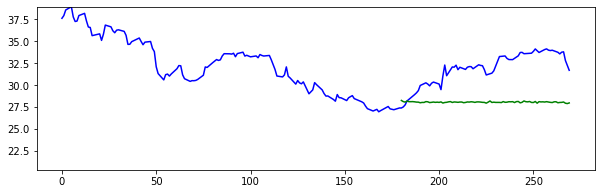

Mean for 0 month = 31.760636101178545
Mean for 1 month = 31.53051186335066
Mean for 2 month = 31.345419357401248


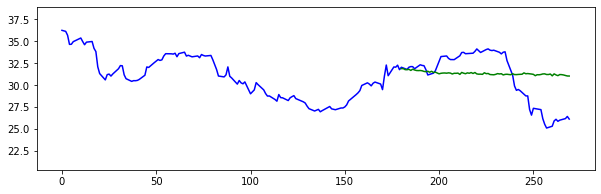

Mean for 0 month = 27.986580368295574
Mean for 1 month = 27.921983879390222
Mean for 2 month = 27.946430334209385


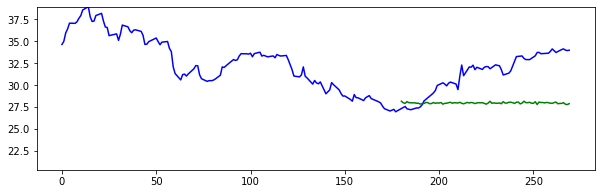

Mean for 0 month = 31.576937603692205
Mean for 1 month = 31.357217011447993
Mean for 2 month = 31.162370782035897


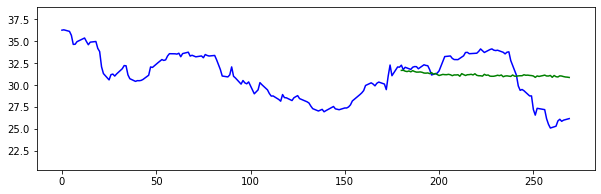

Mean for 0 month = 28.089998030679492
Mean for 1 month = 28.016067277114473
Mean for 2 month = 28.027069037821473


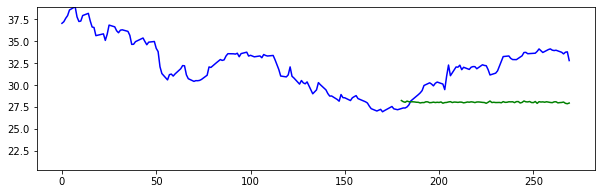

Mean for 0 month = 31.85945138997973
Mean for 1 month = 31.623734664574993
Mean for 2 month = 31.466796371340244


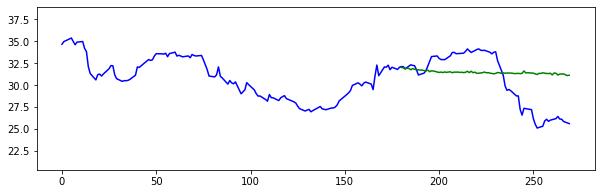

Mean for 0 month = 32.52152781061348
Mean for 1 month = 32.26863962247875
Mean for 2 month = 32.076076125004775


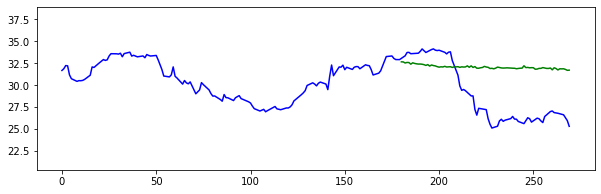

Mean for 0 month = 30.60310212423837
Mean for 1 month = 30.40939464821069
Mean for 2 month = 30.308216026455703


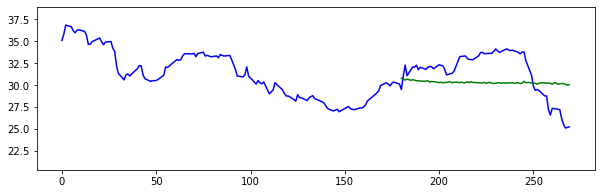

Mean for 0 month = 31.66857528866592
Mean for 1 month = 31.444952495524223
Mean for 2 month = 31.29666941728869


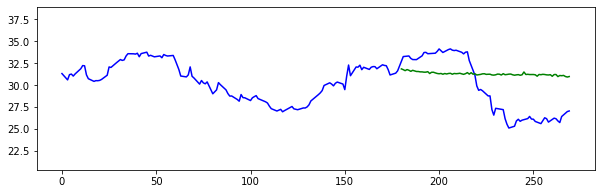

Mean for 0 month = 29.364843172805866
Mean for 1 month = 29.236696785287158
Mean for 2 month = 29.130221175954908


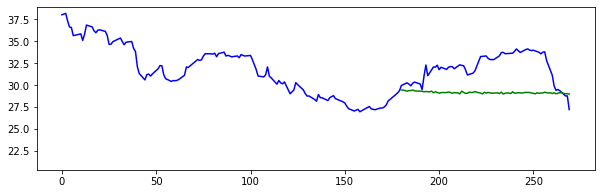

Mean for 0 month = 32.83594825938469
Mean for 1 month = 32.58089173716722
Mean for 2 month = 32.36170211106222


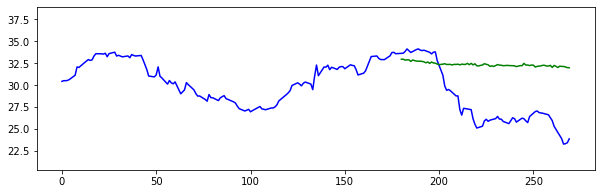

Mean for 0 month = 27.995998513598458
Mean for 1 month = 27.93278474901398
Mean for 2 month = 27.946078969367885


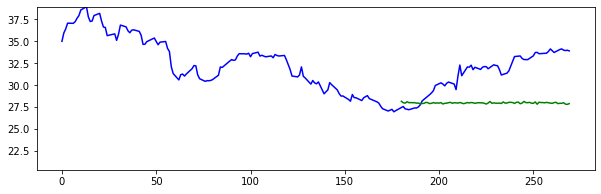

Mean for 0 month = 31.908285488670053
Mean for 1 month = 31.672478601301556
Mean for 2 month = 31.51296140908621


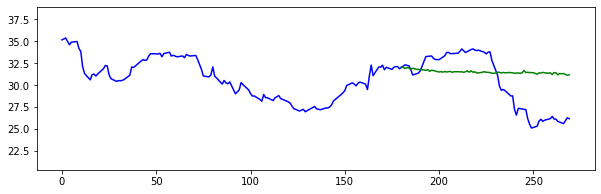

Mean for 0 month = 32.55141211023319
Mean for 1 month = 32.29042390913008
Mean for 2 month = 32.16690224113087


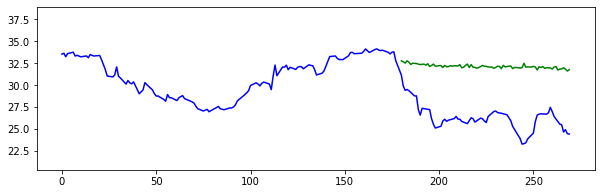

Mean for 0 month = 28.11469935146895
Mean for 1 month = 28.045109657435127
Mean for 2 month = 28.038379750559642


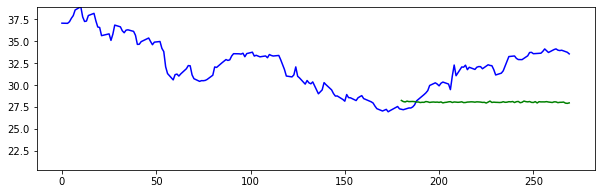

Mean for 0 month = 28.090921329210932
Mean for 1 month = 28.017668457981312
Mean for 2 month = 28.027053529074315


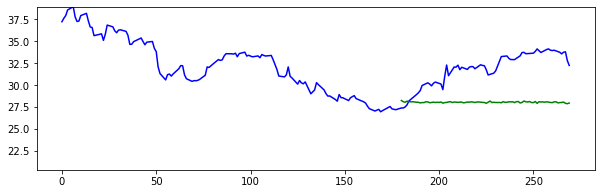

Mean for 0 month = 29.185601188857323
Mean for 1 month = 29.066448318256086
Mean for 2 month = 28.968626645424184


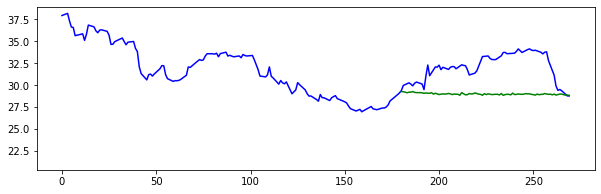

Mean for 0 month = 30.308670505010372
Mean for 1 month = 30.132769183021047
Mean for 2 month = 29.995438504318763


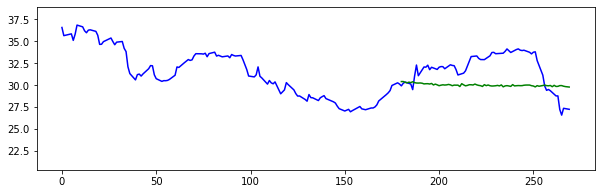

Mean for 0 month = 28.06032307135295
Mean for 1 month = 27.988939698992056
Mean for 2 month = 28.027014896173693


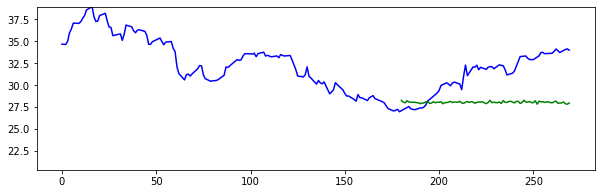

Mean for 0 month = 32.01796723964568
Mean for 1 month = 31.78116523546142
Mean for 2 month = 31.609406138635613


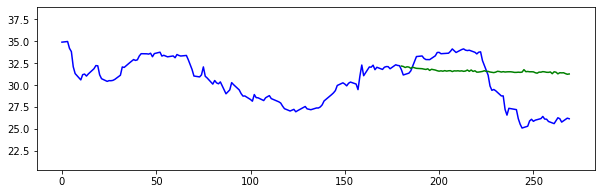

Mean for 0 month = 31.84007879689163
Mean for 1 month = 31.605108047783823
Mean for 2 month = 31.434244344861963


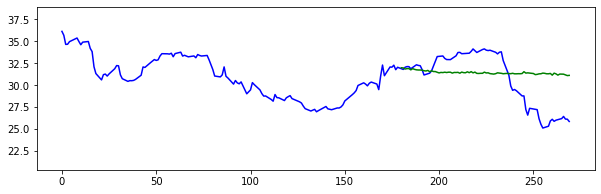

Mean for 0 month = 31.84633121223279
Mean for 1 month = 31.609725429831553
Mean for 2 month = 31.454071527678536


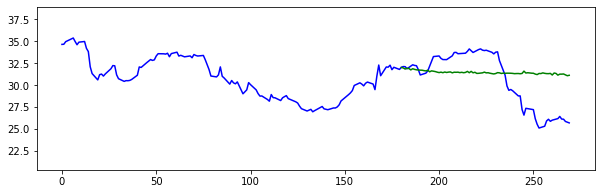

Mean for 0 month = 31.911623815979162
Mean for 1 month = 31.67581214813664
Mean for 2 month = 31.51744693898966


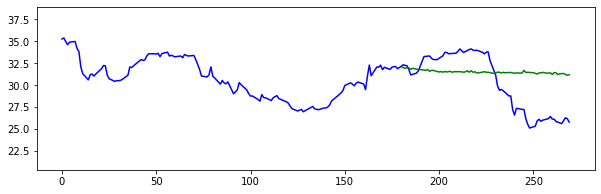

Mean for 0 month = 32.55093128348442
Mean for 1 month = 32.299631657988556
Mean for 2 month = 32.10425546300158


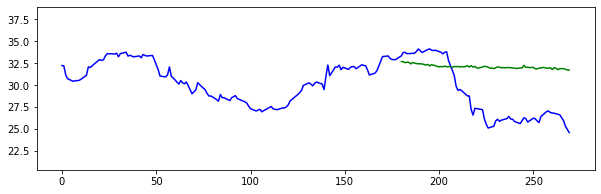

Mean for 0 month = 28.007778324247944
Mean for 1 month = 27.94024512343923
Mean for 2 month = 27.973600658663578


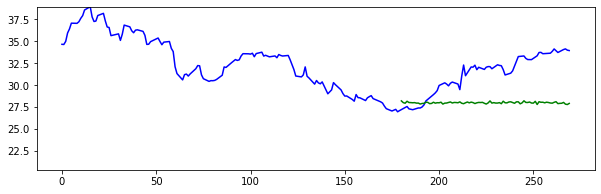

Mean for 0 month = 32.98646026143202
Mean for 1 month = 32.73011334474681
Mean for 2 month = 32.5014925104157


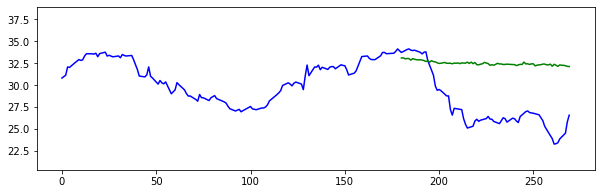

Mean for 0 month = 30.373228249841286
Mean for 1 month = 30.184458002926355
Mean for 2 month = 30.20807810278053


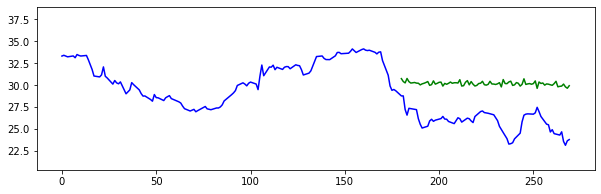

In [48]:
show_sample_predictions(regressorGRU)

GRU x3

In [14]:
from tensorflow.keras.optimizers import SGD

regressorGRU = Sequential()
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(WINDOW_SIZE, 1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(WINDOW_SIZE, 1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
regressorGRU.add(GRU(STEPS_AHEAD))

regressorGRU.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error', metrics=['mae'])
callback = tf.keras.callbacks.EarlyStopping(monitor='loss',  patience=30, restore_best_weights=True)
history = regressorGRU.fit(ds_train,epochs=10,verbose=1,  callbacks=[callback])


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/10
117/117 [==============================] - 8s 32ms/step - loss: 0.0988 - mae: 0.2708
Epoch 2/10
117/117 [==============================] - 4s 32ms/step - loss: 0.0391 - mae: 0.1500
Epoch 3/10
117/117 [==============================] - 4s 31ms/step - loss: 0.0336 - mae: 0.1468
Epoch 4/10
117/117 [==============================] - 4s 31ms/step - loss: 0.0325 - mae: 0.1452
Epoch 5/10
117/117 [==============================] - 4s 32ms/step - loss: 0.0311 - mae: 0.1415
Epoch 6/10
117/117 [==============================] - 4s 32ms/step - loss: 0.0293 - mae: 0.1365
Epoch 7/10
117/117 [==============================] - 4s 32ms/step - loss: 0.0272 - mae: 0.1305
Epoch 8/10
117/117 [==============================] - 4s 31ms/step - loss: 0.0249 - mae: 0.1233
Epoch 9/10
117/117 [==============================] - 4s 32ms/step - loss: 0.0227 - mae: 0.1156
Epoch 10/10
117/117 [==============================] - 4s 32ms/step - loss: 0.0203 - mae: 0.1078


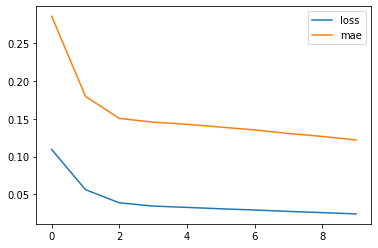

In [16]:
pd.DataFrame(history.history).plot()

Mean for 0 month = 29.114891140705424
Mean for 1 month = 29.17786299106902
Mean for 2 month = 28.553247754638072


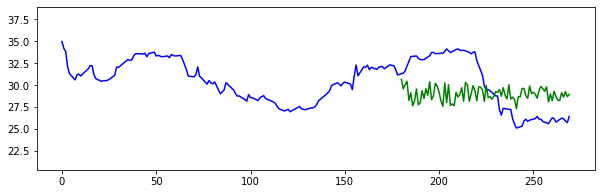

Mean for 0 month = 27.602586234519855
Mean for 1 month = 27.62181919329663
Mean for 2 month = 27.364855651047954


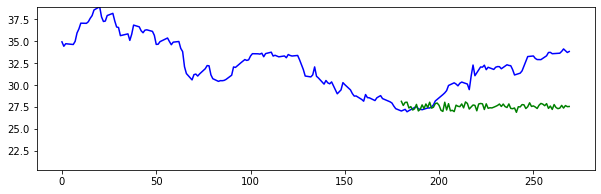

Mean for 0 month = 28.95526333054441
Mean for 1 month = 28.989072010237635
Mean for 2 month = 28.45640935861067


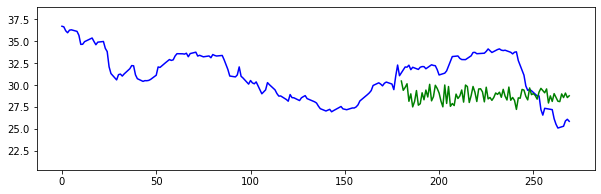

Mean for 0 month = 27.50513888392219
Mean for 1 month = 27.515613958681843
Mean for 2 month = 27.2962053201618


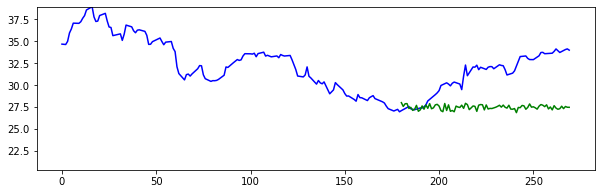

Mean for 0 month = 29.81735417330314
Mean for 1 month = 29.883528440987327
Mean for 2 month = 29.1302316262935


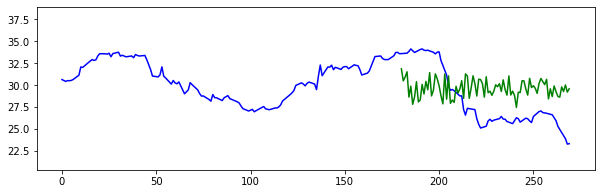

Mean for 0 month = 29.162913114679043
Mean for 1 month = 29.201493152153432
Mean for 2 month = 28.621284684001388


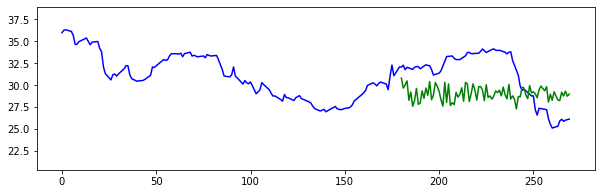

Mean for 0 month = 29.21534068458332
Mean for 1 month = 29.257387621883574
Mean for 2 month = 28.660300078134306


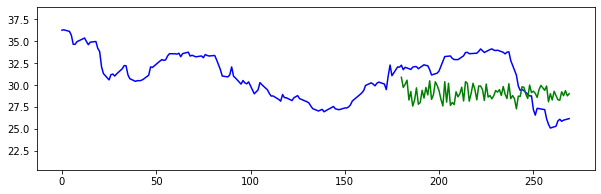

Mean for 0 month = 29.480498570782192
Mean for 1 month = 29.52332316891657
Mean for 2 month = 28.879291425740707


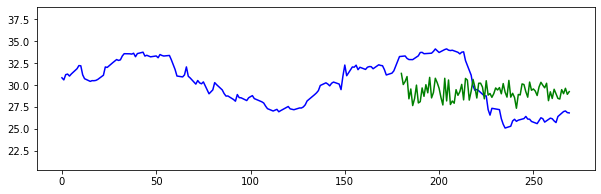

Mean for 0 month = 28.209410825659596
Mean for 1 month = 28.220393797991903
Mean for 2 month = 27.87016921072663


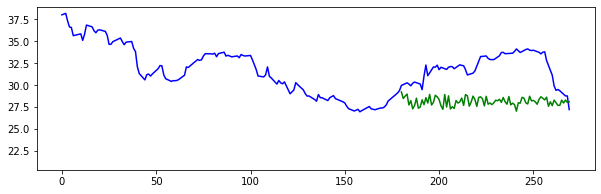

Mean for 0 month = 27.985229995554796
Mean for 1 month = 27.990640324836185
Mean for 2 month = 27.693725527282076


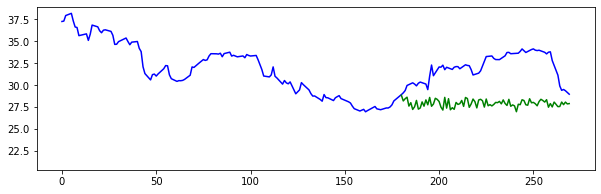

Mean for 0 month = 29.239043330994946
Mean for 1 month = 29.295036189551126
Mean for 2 month = 28.66348537468742


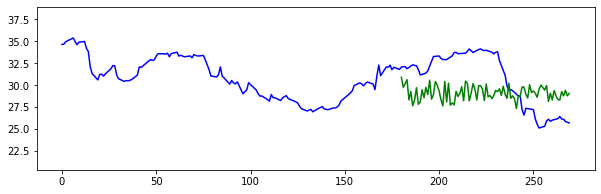

Mean for 0 month = 29.256609571941084
Mean for 1 month = 29.311402642688563
Mean for 2 month = 28.679308910500556


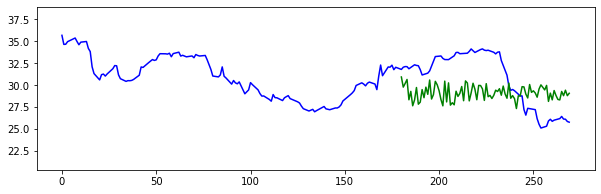

Mean for 0 month = 27.53910409634658
Mean for 1 month = 27.55244489852887
Mean for 2 month = 27.320596021312873


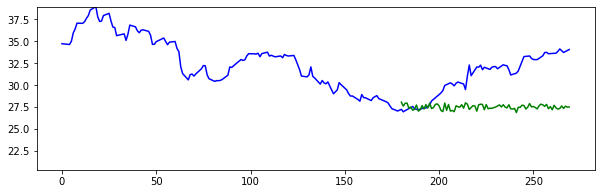

Mean for 0 month = 28.05627773416898
Mean for 1 month = 28.063724545388833
Mean for 2 month = 27.749211155308494


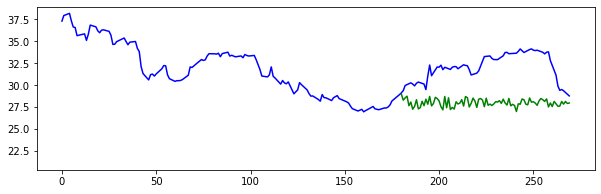

Mean for 0 month = 29.295719463816546
Mean for 1 month = 29.35617961977055
Mean for 2 month = 28.705289452789362


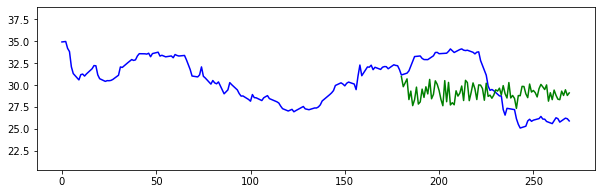

Mean for 0 month = 29.26688392237822
Mean for 1 month = 29.31827462969929
Mean for 2 month = 28.69167266161197


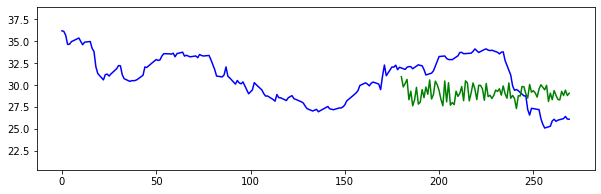

Mean for 0 month = 29.6267477796639
Mean for 1 month = 29.692358396107345
Mean for 2 month = 28.972613505181595


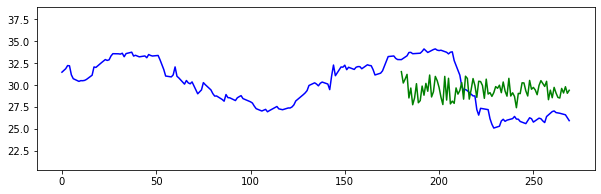

Mean for 0 month = 29.934039040803988
Mean for 1 month = 30.00449377829033
Mean for 2 month = 29.222011613750084


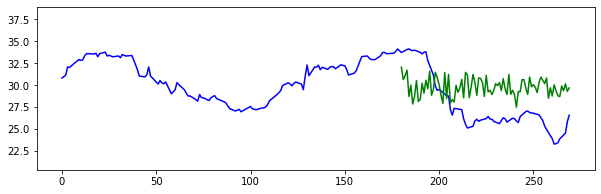

Mean for 0 month = 27.513402822680415
Mean for 1 month = 27.519568800380615
Mean for 2 month = 27.30819813984033


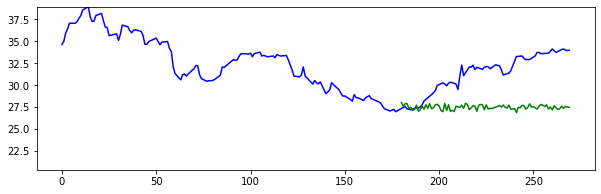

Mean for 0 month = 29.66584649857098
Mean for 1 month = 29.726693150291943
Mean for 2 month = 29.010617717882518


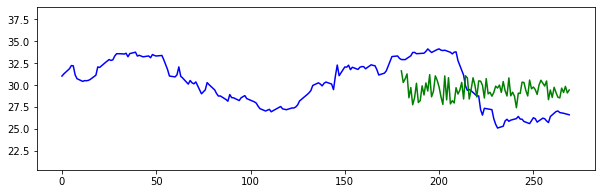

Mean for 0 month = 29.278215869314998
Mean for 1 month = 29.32220167794437
Mean for 2 month = 28.70984257637217


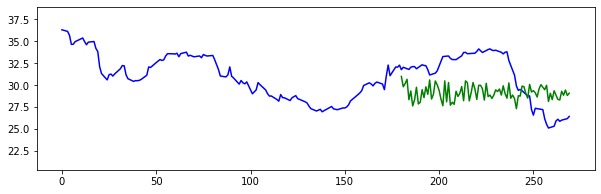

Mean for 0 month = 28.0333173953184
Mean for 1 month = 28.051576971760188
Mean for 2 month = 27.718091936954625


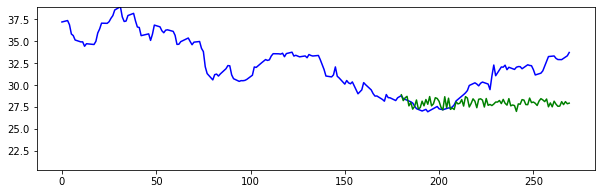

Mean for 0 month = 29.280994769988325
Mean for 1 month = 29.337222983510323
Mean for 2 month = 28.69814853632077


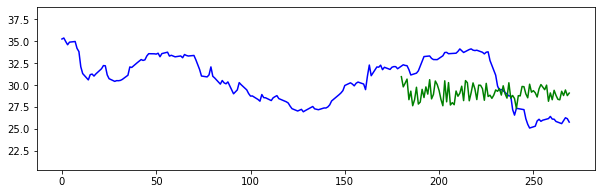

Mean for 0 month = 28.636164965583326
Mean for 1 month = 28.667831103518825
Mean for 2 month = 28.195413986796513


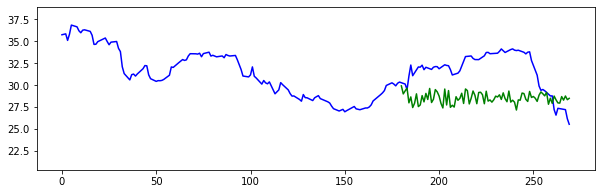

Mean for 0 month = 29.912448585698666
Mean for 1 month = 29.985722524366178
Mean for 2 month = 29.20082688748168


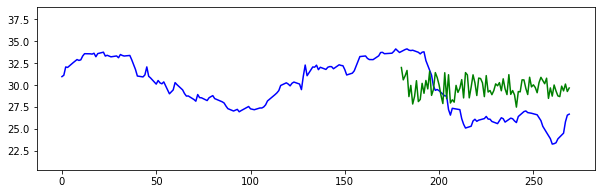

Mean for 0 month = 27.92528023858427
Mean for 1 month = 27.94756247275182
Mean for 2 month = 27.62436940943303


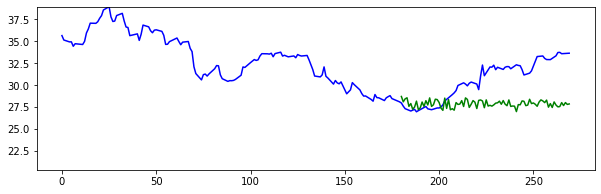

Mean for 0 month = 27.56887255285132
Mean for 1 month = 27.572437452394883
Mean for 2 month = 27.356498270698445


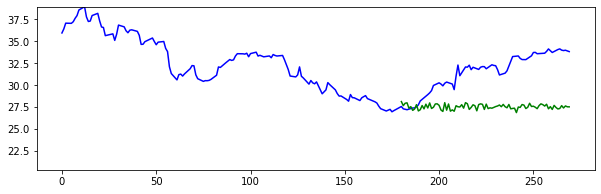

Mean for 0 month = 29.892065867329812
Mean for 1 month = 29.96608728314076
Mean for 2 month = 29.183242469616822


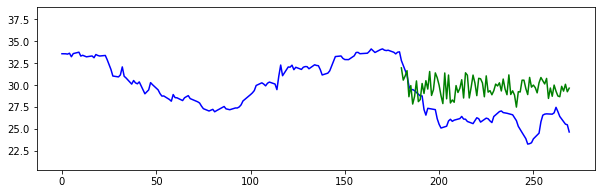

Mean for 0 month = 27.537606751822715
Mean for 1 month = 27.54216109831749
Mean for 2 month = 27.329874810238977


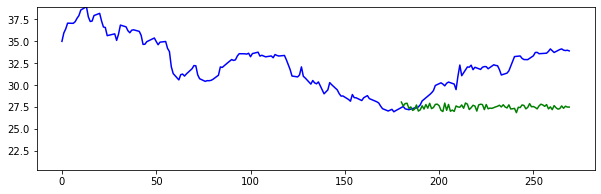

Mean for 0 month = 29.824358735087948
Mean for 1 month = 29.892243967781035
Mean for 2 month = 29.13400681110764


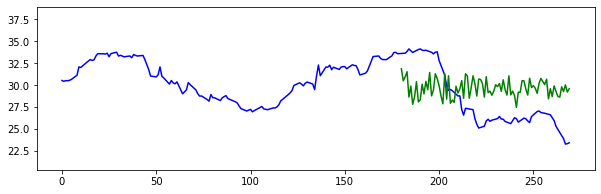

Mean for 0 month = 29.88188918308894
Mean for 1 month = 29.959216574628897
Mean for 2 month = 29.170903121157743


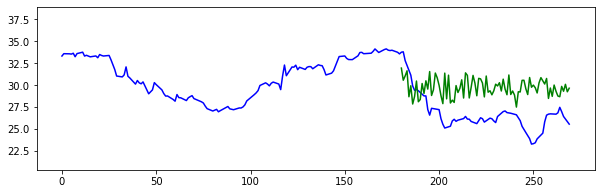

Mean for 0 month = 28.43516054063806
Mean for 1 month = 28.44883775478376
Mean for 2 month = 28.05205374066471


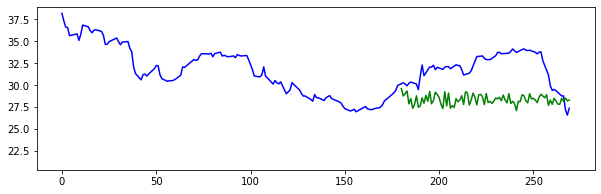

In [20]:
show_sample_predictions(regressorGRU)

GRU + DENSE


In [15]:
regressorGRU = Sequential()
regressorGRU.add(GRU(units=50, input_shape=(WINDOW_SIZE, 1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
regressorGRU.add(Dense(STEPS_AHEAD))

regressorGRU.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error', metrics=['mae'])
history = regressorGRU.fit(ds_train,epochs=10,verbose=1,  callbacks=[callback])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/10
117/117 [==============================] - 5s 13ms/step - loss: 0.1095 - mae: 0.2856
Epoch 2/10
117/117 [==============================] - 2s 13ms/step - loss: 0.0563 - mae: 0.1797
Epoch 3/10
117/117 [==============================] - 2s 13ms/step - loss: 0.0390 - mae: 0.1505
Epoch 4/10
117/117 [==============================] - 2s 13ms/step - loss: 0.0347 - mae: 0.1456
Epoch 5/10
117/117 [==============================] - 2s 13ms/step - loss: 0.0329 - mae: 0.1427
Epoch 6/10
117/117 [==============================] - 2s 13ms/step - loss: 0.0311 - mae: 0.1391
Epoch 7/10
117/117 [==============================] - 2s 13ms/step - loss: 0.0294 - mae: 0.1353
Epoch 8/10
117/117 [==============================] - 2s 13ms/step - loss: 0.0276 - mae: 0.1306
Epoch 9/10
117/117 [==============================] - 2s 13ms/step - loss: 0.0260 - mae: 0.1267
Epoch 10/10
117/117 [==============================] - 2s 13ms/step - loss: 0.0243 - mae: 0.1221


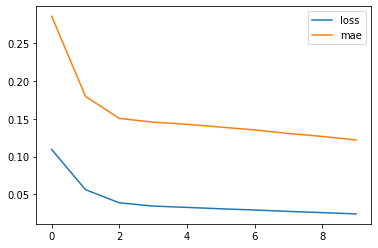

In [21]:
pd.DataFrame(history.history).plot()

Mean for 0 month = 28.01927636486395
Mean for 1 month = 28.0412245217182
Mean for 2 month = 27.70160430435912


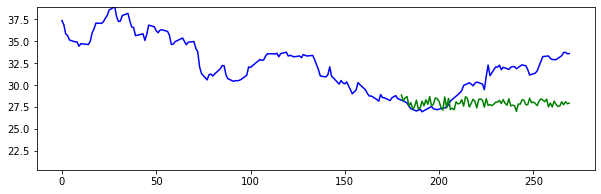

Mean for 0 month = 29.81735417330314
Mean for 1 month = 29.883528440987327
Mean for 2 month = 29.1302316262935


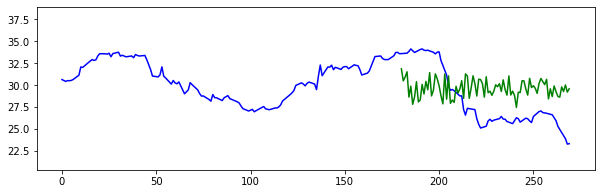

Mean for 0 month = 28.128428761720677
Mean for 1 month = 28.137837957531474
Mean for 2 month = 27.805783562960933


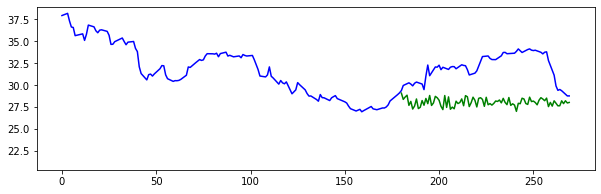

Mean for 0 month = 28.070135439002918
Mean for 1 month = 28.0876378661794
Mean for 2 month = 27.749108708638214


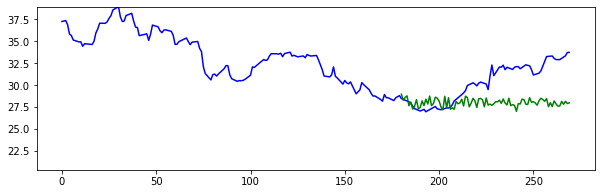

Mean for 0 month = 29.76350280035345
Mean for 1 month = 29.82528308977063
Mean for 2 month = 29.090749357725564


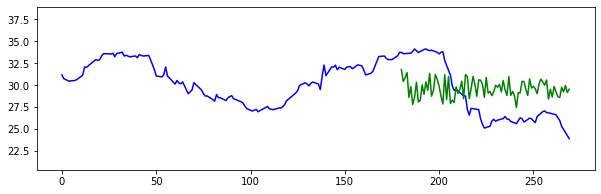

Mean for 0 month = 29.6267477796639
Mean for 1 month = 29.692358396107345
Mean for 2 month = 28.972613505181595


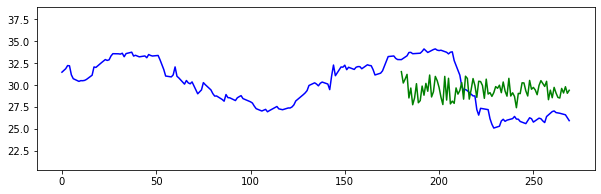

Mean for 0 month = 27.53910409634658
Mean for 1 month = 27.55244489852887
Mean for 2 month = 27.320596021312873


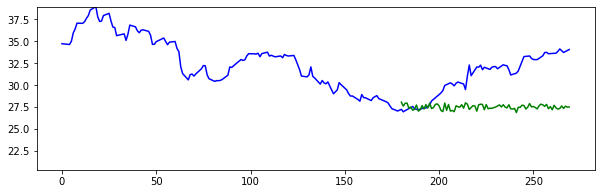

Mean for 0 month = 28.64893377848876
Mean for 1 month = 28.682631951410134
Mean for 2 month = 28.203570364888968


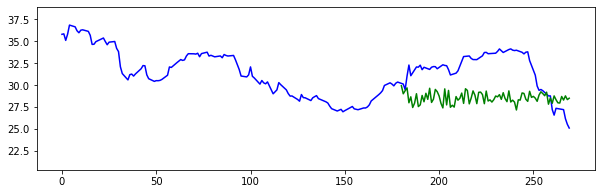

Mean for 0 month = 29.084797500792558
Mean for 1 month = 29.14447210257159
Mean for 2 month = 28.53249543892211


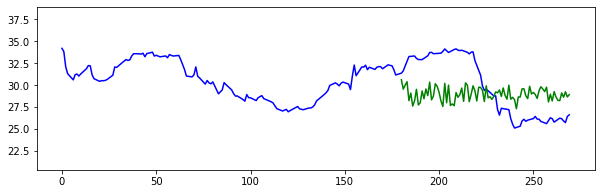

Mean for 0 month = 27.6605861139536
Mean for 1 month = 27.664572306668127
Mean for 2 month = 27.430490225448473


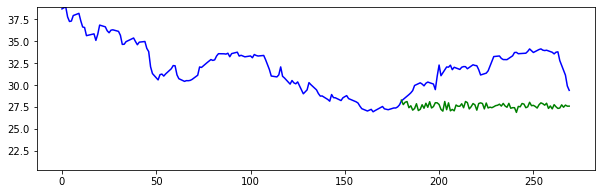

Mean for 0 month = 28.691750761216827
Mean for 1 month = 28.722959252143937
Mean for 2 month = 28.242464301629276


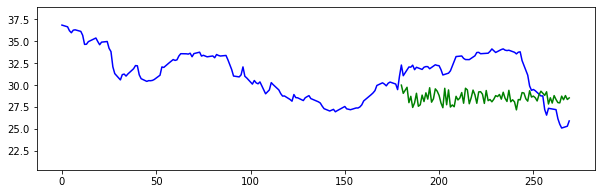

Mean for 0 month = 29.26688392237822
Mean for 1 month = 29.31827462969929
Mean for 2 month = 28.69167266161197


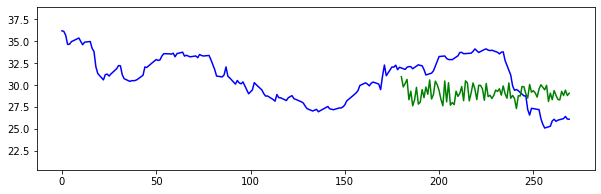

Mean for 0 month = 27.58221885813744
Mean for 1 month = 27.587802507396013
Mean for 2 month = 27.364468321477386


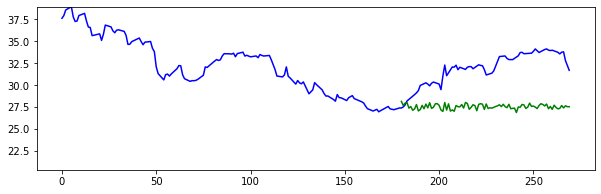

Mean for 0 month = 29.918419175419455
Mean for 1 month = 29.994934386655814
Mean for 2 month = 29.20211594786362


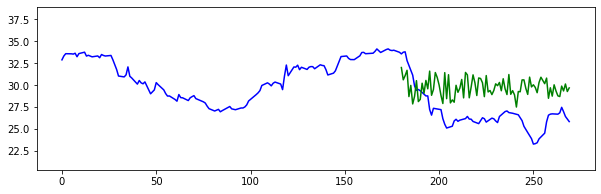

Mean for 0 month = 29.114891140705424
Mean for 1 month = 29.17786299106902
Mean for 2 month = 28.553247754638072


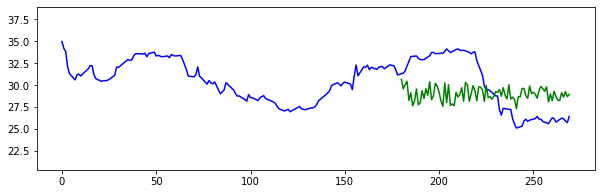

Mean for 0 month = 29.836324428355674
Mean for 1 month = 29.905996946881487
Mean for 2 month = 29.14180782210127


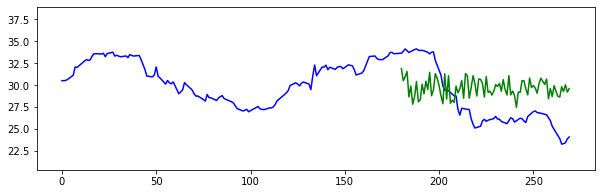

Mean for 0 month = 29.809283176700404
Mean for 1 month = 29.872343521420543
Mean for 2 month = 29.127202584536995


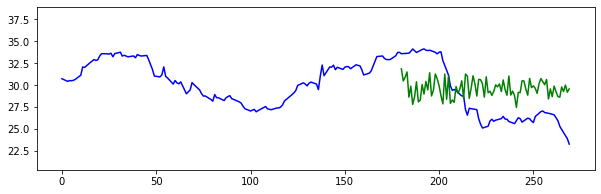

Mean for 0 month = 29.914016636768718
Mean for 1 month = 29.987268563020905
Mean for 2 month = 29.2021542472428


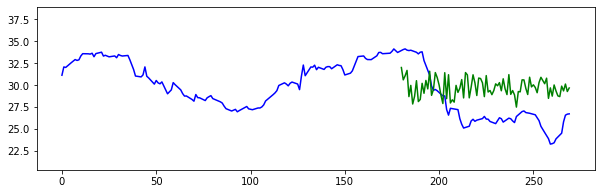

Mean for 0 month = 29.261595106076346
Mean for 1 month = 29.315991008370652
Mean for 2 month = 28.684123236961103


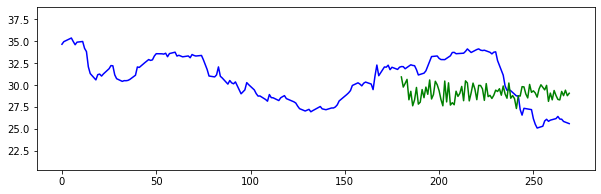

Mean for 0 month = 29.912448585698666
Mean for 1 month = 29.985722524366178
Mean for 2 month = 29.20082688748168


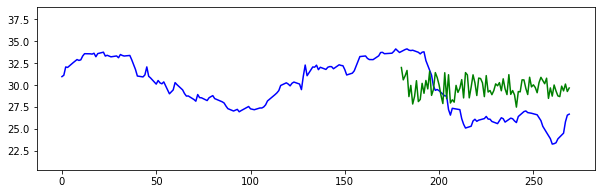

Mean for 0 month = 27.59301455817881
Mean for 1 month = 27.59875179406246
Mean for 2 month = 27.37300563664606


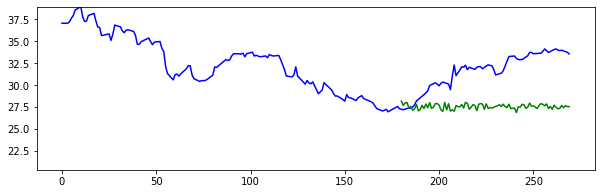

Mean for 0 month = 29.446710013549428
Mean for 1 month = 29.53115692059864
Mean for 2 month = 28.802641471840882


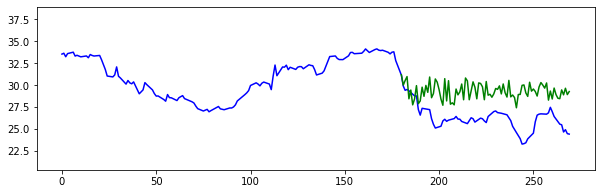

Mean for 0 month = 29.765222325746084
Mean for 1 month = 29.84580877766524
Mean for 2 month = 29.07049949206533


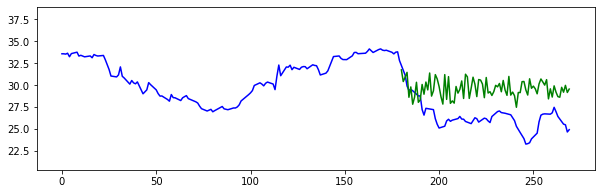

Mean for 0 month = 29.872293604377724
Mean for 1 month = 29.941569677080157
Mean for 2 month = 29.17212720044497


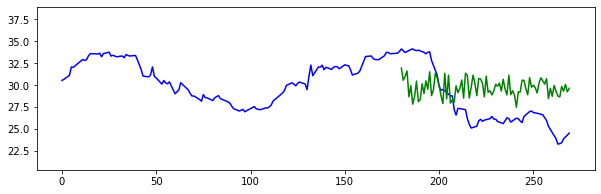

Mean for 0 month = 27.91180335965273
Mean for 1 month = 27.91534469034757
Mean for 2 month = 27.636161504789037


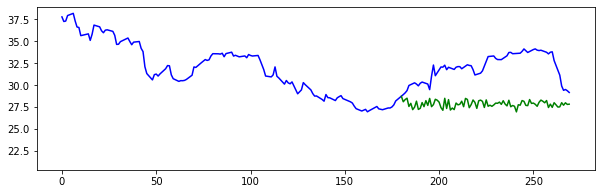

Mean for 0 month = 29.616405891134313
Mean for 1 month = 29.682481881166275
Mean for 2 month = 28.963582856209996


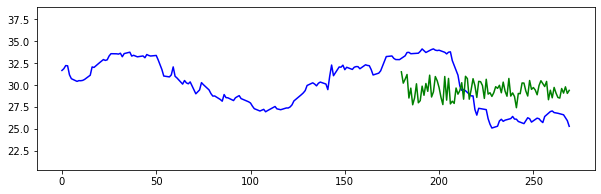

Mean for 0 month = 27.72445875015116
Mean for 1 month = 27.748082741088854
Mean for 2 month = 27.458588684495044


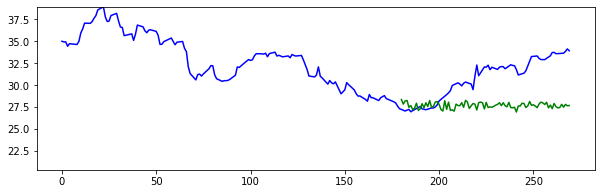

Mean for 0 month = 27.537606751822715
Mean for 1 month = 27.54216109831749
Mean for 2 month = 27.329874810238977


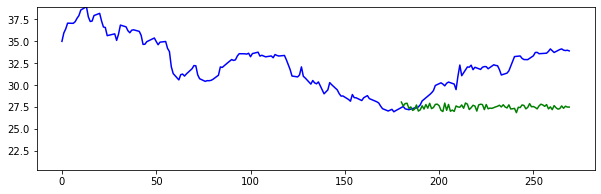

Mean for 0 month = 29.10467443389124
Mean for 1 month = 29.157500283986828
Mean for 2 month = 28.5571954256258


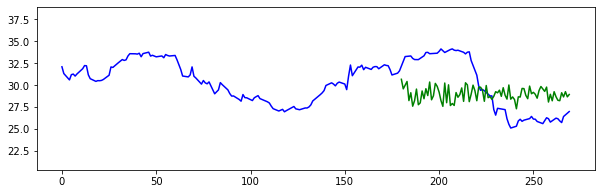

Mean for 0 month = 29.267304214984858
Mean for 1 month = 29.32045274707774
Mean for 2 month = 28.69000099654658


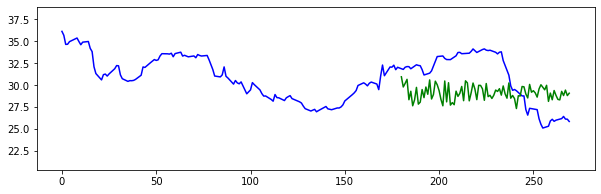

Mean for 0 month = 29.21534068458332
Mean for 1 month = 29.257387621883574
Mean for 2 month = 28.660300078134306


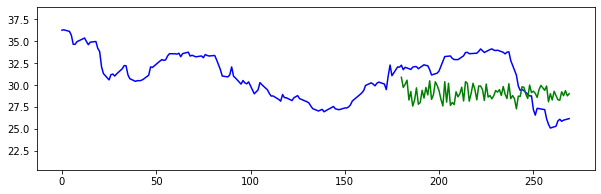

Mean for 0 month = 29.95545639827974
Mean for 1 month = 30.0310886114925
Mean for 2 month = 29.233827667063167


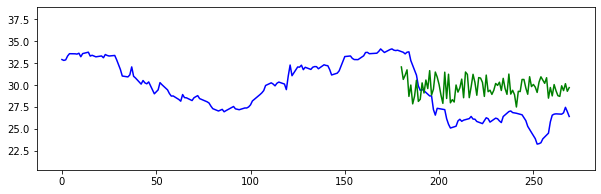

In [22]:
show_sample_predictions(regressorGRU)

GRU x2 + DENSE

In [23]:
regressorGRU = Sequential()
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(WINDOW_SIZE, 1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
regressorGRU.add(GRU(units=50, activation='tanh'))
regressorGRU.add(Dropout(0.2))
regressorGRU.add(Dense(STEPS_AHEAD))

regressorGRU.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error', metrics=['mae'])
history = regressorGRU.fit(ds_train,epochs=10, verbose=1,  callbacks=[callback])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/10
117/117 [==============================] - 6s 21ms/step - loss: 0.1067 - mae: 0.2815
Epoch 2/10
117/117 [==============================] - 3s 21ms/step - loss: 0.0549 - mae: 0.1791
Epoch 3/10
117/117 [==============================] - 3s 21ms/step - loss: 0.0421 - mae: 0.1593
Epoch 4/10
117/117 [==============================] - 3s 21ms/step - loss: 0.0386 - mae: 0.1546
Epoch 5/10
117/117 [==============================] - 3s 21ms/step - loss: 0.0368 - mae: 0.1516
Epoch 6/10
117/117 [==============================] - 2s 21ms/step - loss: 0.0345 - mae: 0.1466
Epoch 7/10
117/117 [==============================] - 3s 21ms/step - loss: 0.0320 - mae: 0.1406
Epoch 8/10
117/117 [==============================] - 2s 21ms/step - loss: 0.0293 - mae: 0.1342
Epoch 9/10
117/117 [==============================] - 3s 21ms/step - loss: 0.0271 - mae: 0.1277
Epoch 10/10
117/117 [==============================] - 3s 21ms/step - loss: 0.0246 - mae: 0.1204


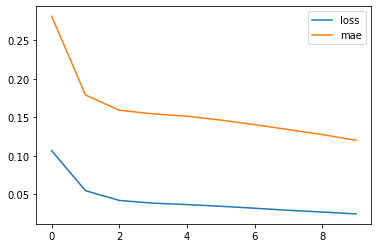

In [24]:
pd.DataFrame(history.history).plot()

Mean for 0 month = 28.69293281680209
Mean for 1 month = 28.499582597828084
Mean for 2 month = 28.498963248506147


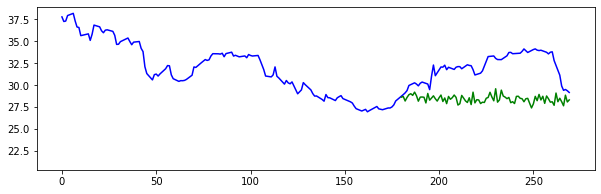

Mean for 0 month = 28.605479603041488
Mean for 1 month = 28.42625735244506
Mean for 2 month = 28.428663487317557


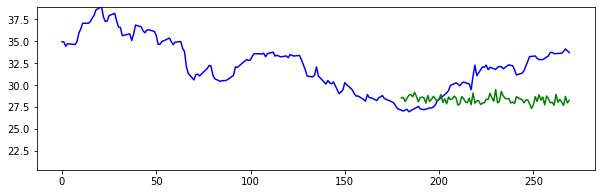

Mean for 0 month = 30.42141487223455
Mean for 1 month = 29.993677900201583
Mean for 2 month = 29.97045680316852


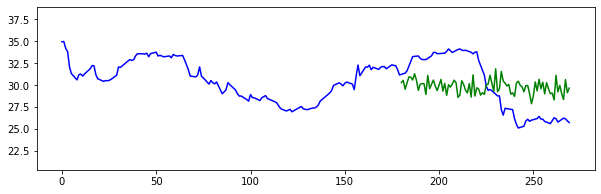

Mean for 0 month = 28.405025599653015
Mean for 1 month = 28.253250385135676
Mean for 2 month = 28.255565079545534


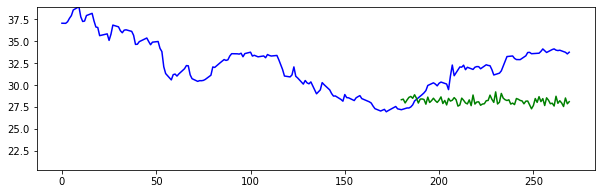

Mean for 0 month = 30.494995039174775
Mean for 1 month = 30.053313479971642
Mean for 2 month = 30.030985553366225


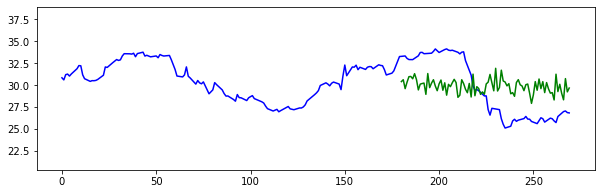

Mean for 0 month = 29.675851419268078
Mean for 1 month = 29.34959762965558
Mean for 2 month = 29.336493294177252


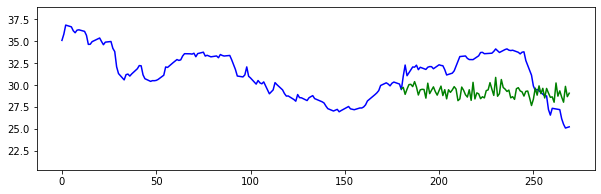

Mean for 0 month = 28.386924279136515
Mean for 1 month = 28.236011717834668
Mean for 2 month = 28.24232538994776


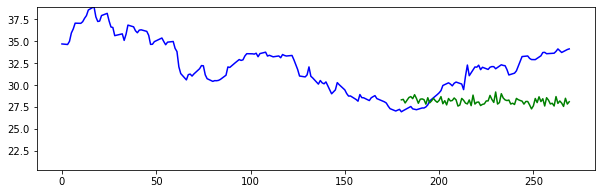

Mean for 0 month = 30.88246413287792
Mean for 1 month = 30.390641182096903
Mean for 2 month = 30.360128694836995


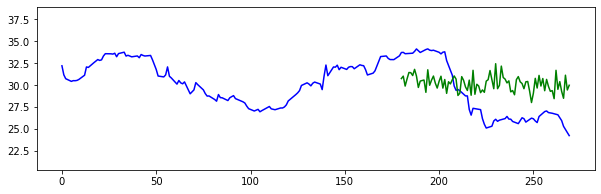

Mean for 0 month = 29.631157099917345
Mean for 1 month = 29.311784302394575
Mean for 2 month = 29.299185696599512


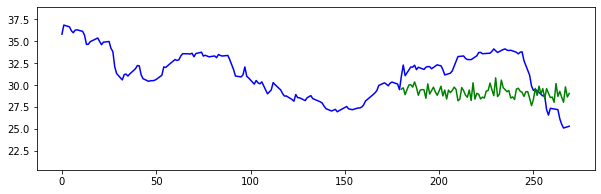

Mean for 0 month = 28.605159533628846
Mean for 1 month = 28.423602577335902
Mean for 2 month = 28.42464594358727


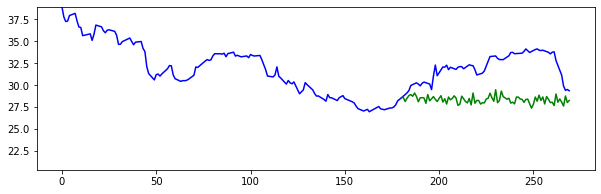

Mean for 0 month = 28.33308919315068
Mean for 1 month = 28.190119278282452
Mean for 2 month = 28.19598897776636


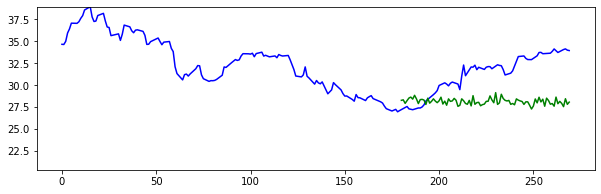

Mean for 0 month = 30.719393380848118
Mean for 1 month = 30.251002646174356
Mean for 2 month = 30.220020171612624


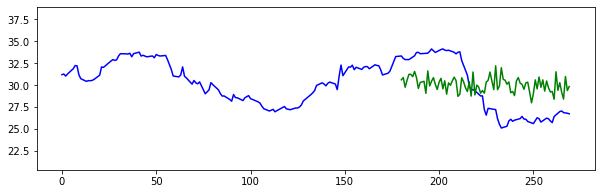

Mean for 0 month = 29.047985404907127
Mean for 1 month = 28.80691955140602
Mean for 2 month = 28.800314103616138


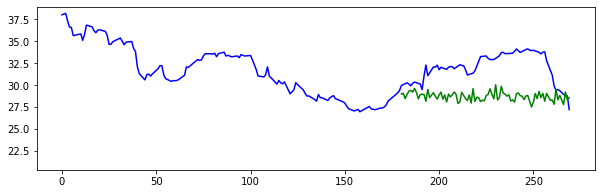

Mean for 0 month = 31.233096005413508
Mean for 1 month = 30.69448310887385
Mean for 2 month = 30.656626423825095


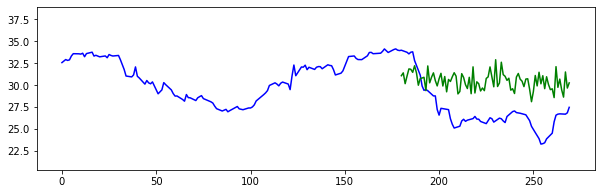

Mean for 0 month = 30.00888053025937
Mean for 1 month = 29.636637857810378
Mean for 2 month = 29.617936365454977


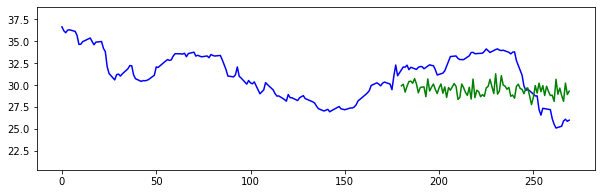

Mean for 0 month = 30.617098240471666
Mean for 1 month = 30.160740292462833
Mean for 2 month = 30.133758240863916


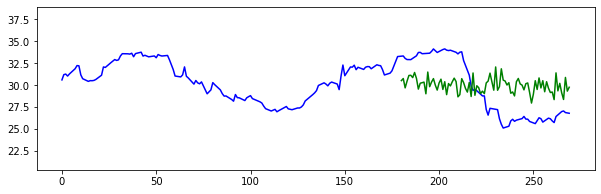

Mean for 0 month = 30.407283457468715
Mean for 1 month = 29.982051620590266
Mean for 2 month = 29.9567228903773


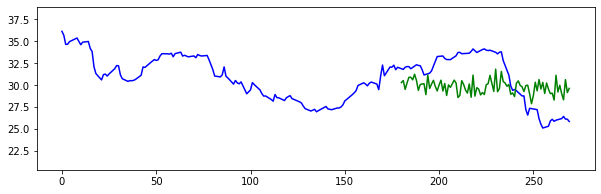

Mean for 0 month = 30.79898282599666
Mean for 1 month = 30.320993455331774
Mean for 2 month = 30.287302675469086


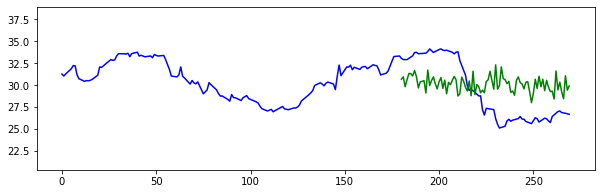

Mean for 0 month = 28.396218799157406
Mean for 1 month = 28.245141922957373
Mean for 2 month = 28.24823689078601


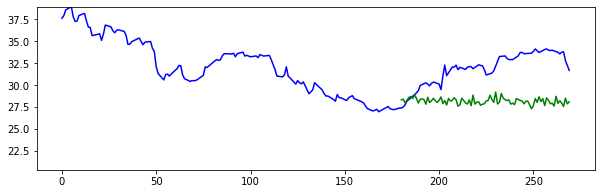

Mean for 0 month = 29.59800923737895
Mean for 1 month = 29.28332597370968
Mean for 2 month = 29.26906220651739


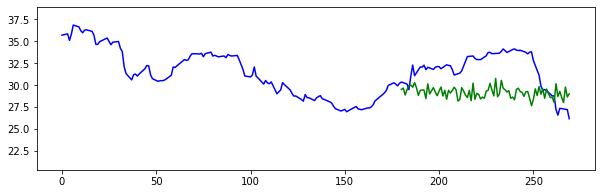

Mean for 0 month = 31.177388029757605
Mean for 1 month = 30.64569092271168
Mean for 2 month = 30.61017427970255


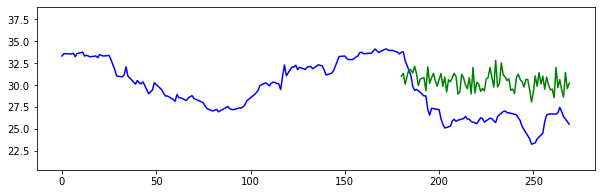

Mean for 0 month = 28.82894130532563
Mean for 1 month = 28.618399945856417
Mean for 2 month = 28.617706110078608


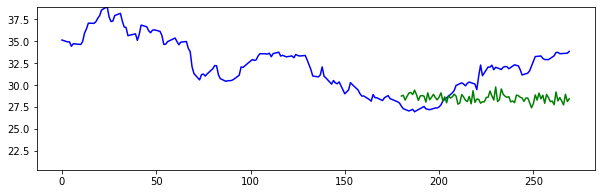

Mean for 0 month = 31.218624176426925
Mean for 1 month = 30.68149122570913
Mean for 2 month = 30.644299804767805


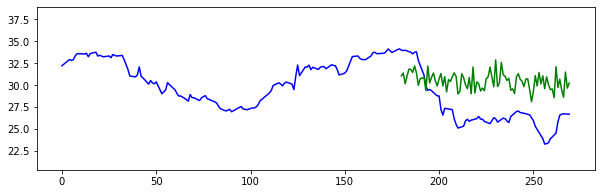

Mean for 0 month = 28.523118817039027
Mean for 1 month = 28.353014820380217
Mean for 2 month = 28.35527854159602


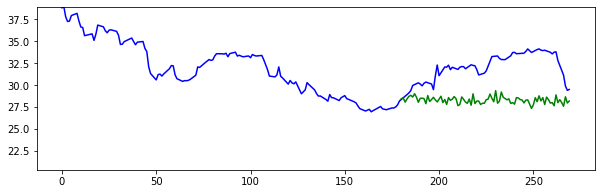

Mean for 0 month = 31.136594466044773
Mean for 1 month = 30.610482842625366
Mean for 2 month = 30.57475374645626


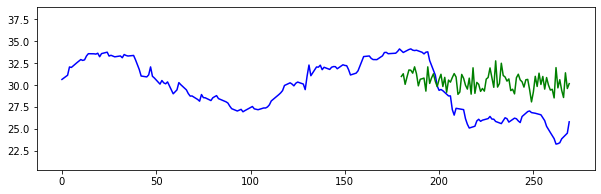

Mean for 0 month = 30.288437093074727
Mean for 1 month = 29.876665125534156
Mean for 2 month = 29.858501603268298


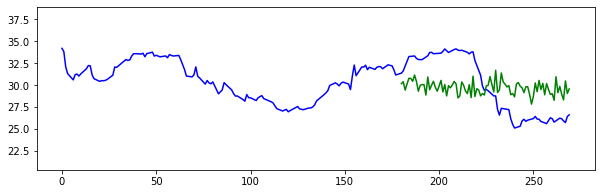

Mean for 0 month = 30.43814130618412
Mean for 1 month = 30.007089631277676
Mean for 2 month = 29.984037740790654


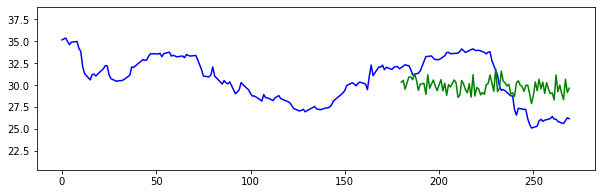

Mean for 0 month = 28.327634561104123
Mean for 1 month = 28.185166596009452
Mean for 2 month = 28.19093095830389


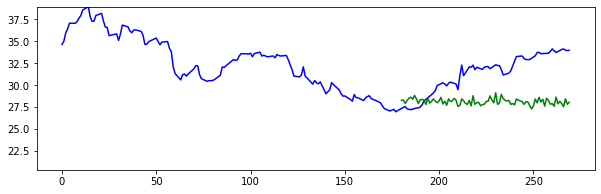

Mean for 0 month = 28.392732555087782
Mean for 1 month = 28.241035606936016
Mean for 2 month = 28.245090282720422


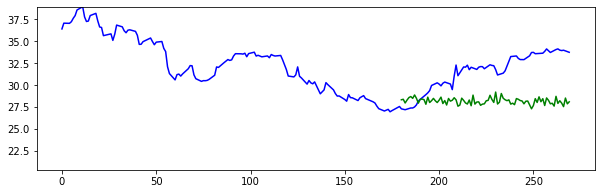

Mean for 0 month = 31.05874878218048
Mean for 1 month = 30.544373667209708
Mean for 2 month = 30.50878687352347


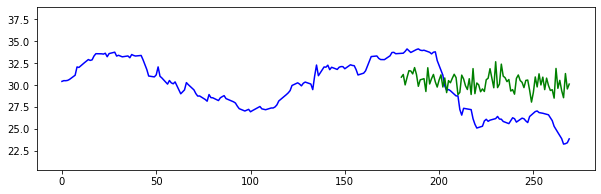

Mean for 0 month = 29.389134484566558
Mean for 1 month = 29.10178586024967
Mean for 2 month = 29.090001157952344


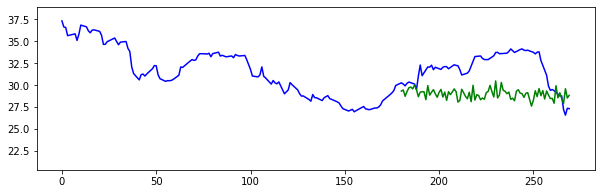

Mean for 0 month = 28.337452376271006
Mean for 1 month = 28.193429478616434
Mean for 2 month = 28.198858707446334


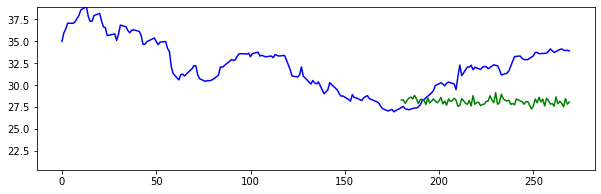

In [25]:
show_sample_predictions(regressorGRU)

GRU x4 + DENSE

In [26]:
regressorGRU = Sequential()
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(WINDOW_SIZE, 1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(WINDOW_SIZE, 1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(WINDOW_SIZE, 1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
regressorGRU.add(GRU(units=50, activation='tanh'))
regressorGRU.add(Dropout(0.2))
regressorGRU.add(Dense(STEPS_AHEAD))

regressorGRU.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error', metrics=['mae'])
history = regressorGRU.fit(ds_train,epochs=10,verbose=1,  callbacks=[callback])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/10
117/117 [==============================] - 11s 39ms/step - loss: 0.1043 - mae: 0.2768
Epoch 2/10
117/117 [==============================] - 5s 39ms/step - loss: 0.0530 - mae: 0.1760
Epoch 3/10
117/117 [==============================] - 5s 39ms/step - loss: 0.0419 - mae: 0.1585
Epoch 4/10
117/117 [==============================] - 5s 39ms/step - loss: 0.0394 - mae: 0.1546
Epoch 5/10
117/117 [==============================] - 5s 39ms/step - loss: 0.0367 - mae: 0.1487
Epoch 6/10
117/117 [==============================] - 5s 39ms/step - loss: 0.0337 - mae: 0.1418
Epoch 7/10
117/117 [==============================] - 5s 39ms/step - loss: 0.0311 - mae: 0.1350
Epoch 8/10
117/117 [==============================] - 5s 39ms/step - loss: 0.0285 - mae: 0.1275
Epoch 9/10
117/117 [==============================] - 5s 39ms/step - loss: 0.0258 - mae: 0.1197
Epoch 10/10
117/117 [==============================] - 5s 39ms/step - loss: 0.0232 - mae: 0.1124


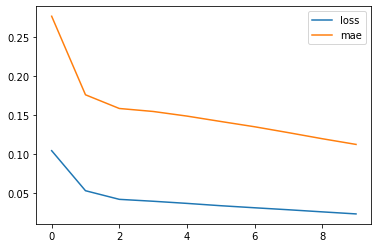

In [27]:
pd.DataFrame(history.history).plot()

Mean for 0 month = 30.74726182127199
Mean for 1 month = 30.682494569387188
Mean for 2 month = 30.782488189450834


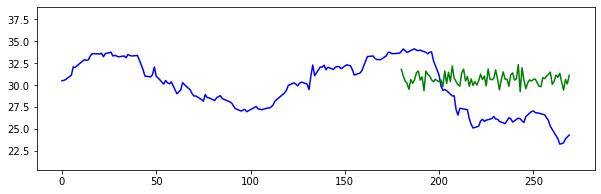

Mean for 0 month = 30.26064169384714
Mean for 1 month = 30.19841042785045
Mean for 2 month = 30.29000364329827


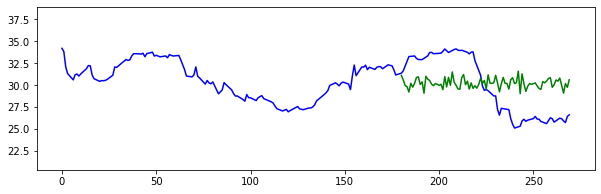

Mean for 0 month = 28.73278523858621
Mean for 1 month = 28.705382894380655
Mean for 2 month = 28.743299613289373


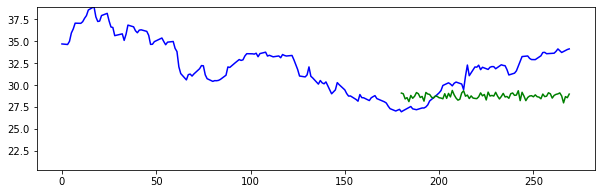

Mean for 0 month = 30.291428113386576
Mean for 1 month = 30.237894308438705
Mean for 2 month = 30.319992001608576


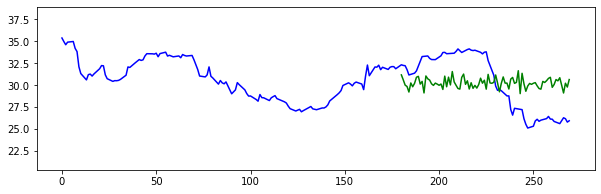

Mean for 0 month = 30.12979611728028
Mean for 1 month = 30.101027835999872
Mean for 2 month = 30.15454991211029


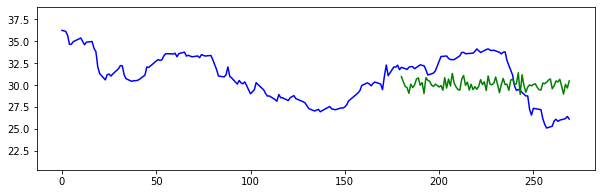

Mean for 0 month = 28.83124738376485
Mean for 1 month = 28.801376202655284
Mean for 2 month = 28.84321607872558


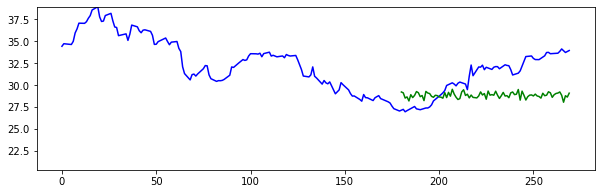

Mean for 0 month = 28.942403466284695
Mean for 1 month = 28.914112120669547
Mean for 2 month = 28.95524026197785


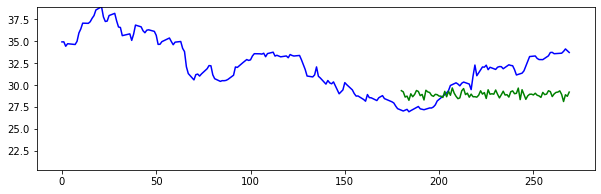

Mean for 0 month = 29.103790490890212
Mean for 1 month = 29.078938640755588
Mean for 2 month = 29.11686397563495


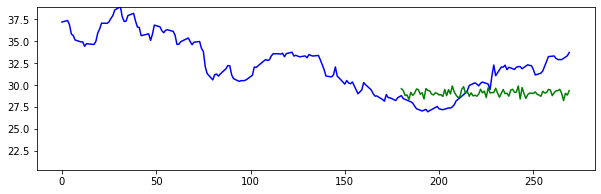

Mean for 0 month = 28.685144813144785
Mean for 1 month = 28.680317423761
Mean for 2 month = 28.69229606877815


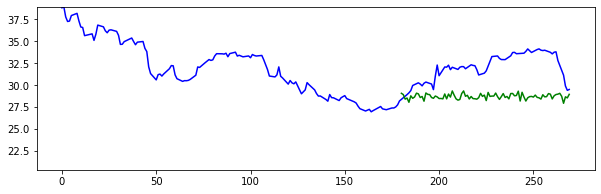

Mean for 0 month = 30.716062335423874
Mean for 1 month = 30.654033906052188
Mean for 2 month = 30.75053338870535


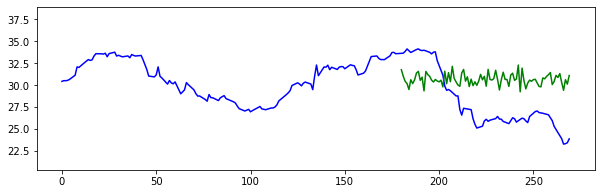

Mean for 0 month = 30.590706577415936
Mean for 1 month = 30.531569000749023
Mean for 2 month = 30.623869726353867


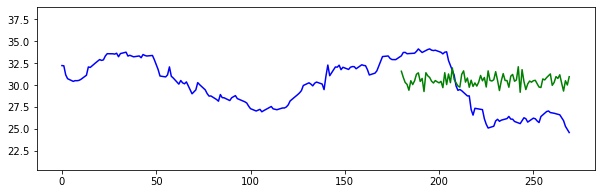

Mean for 0 month = 29.104993391565728
Mean for 1 month = 29.082163570773655
Mean for 2 month = 29.11777093161562


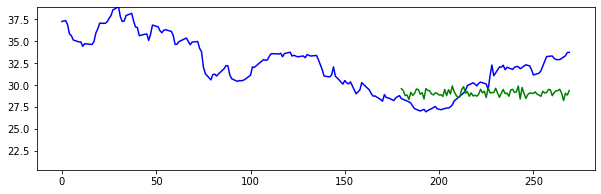

Mean for 0 month = 30.83998917639091
Mean for 1 month = 30.76924088444674
Mean for 2 month = 30.876710665617328


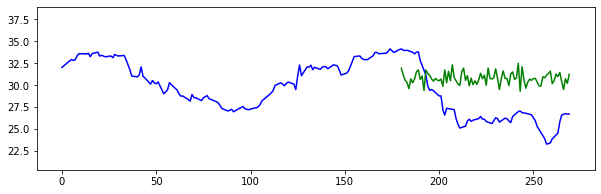

Mean for 0 month = 30.234995340045458
Mean for 1 month = 30.18346649925956
Mean for 2 month = 30.26132524604709


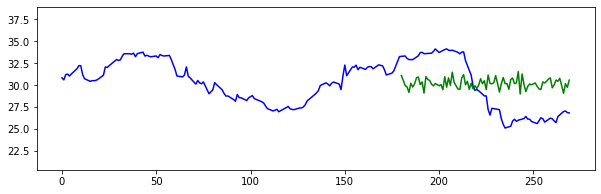

Mean for 0 month = 30.733309229587167
Mean for 1 month = 30.66999424124436
Mean for 2 month = 30.768197907303723


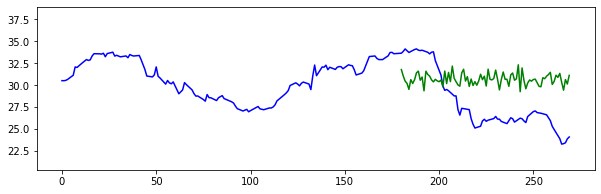

Mean for 0 month = 29.10478116075339
Mean for 1 month = 29.10846818473244
Mean for 2 month = 29.11462454589767


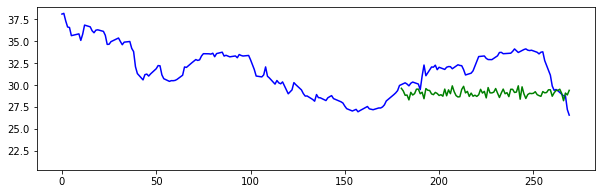

Mean for 0 month = 29.10680096661964
Mean for 1 month = 29.08613697849949
Mean for 2 month = 29.11969346039398


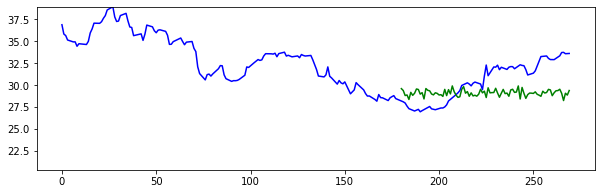

Mean for 0 month = 29.0314026075262
Mean for 1 month = 29.006499839784432
Mean for 2 month = 29.04446886597298


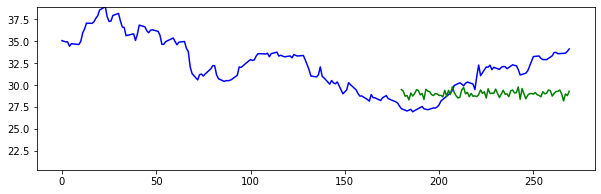

Mean for 0 month = 28.628668848776634
Mean for 1 month = 28.620001293483988
Mean for 2 month = 28.63566696248019


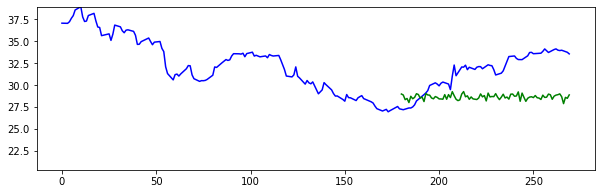

Mean for 0 month = 29.765524774109092
Mean for 1 month = 29.73893738955251
Mean for 2 month = 29.785066851677765


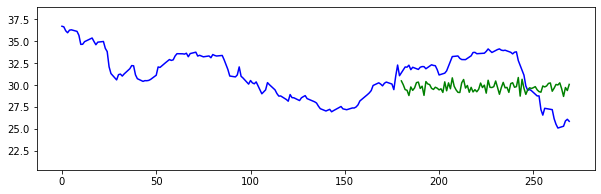

Mean for 0 month = 30.300287943791822
Mean for 1 month = 30.246608612320443
Mean for 2 month = 30.328849219429173


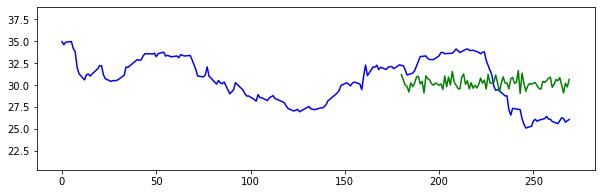

Mean for 0 month = 28.62024793259199
Mean for 1 month = 28.603235003721824
Mean for 2 month = 28.628251446689177


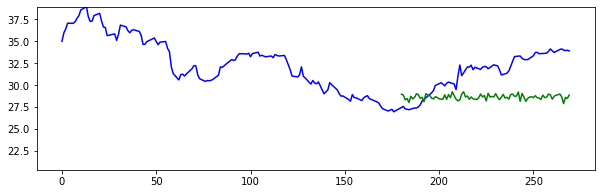

Mean for 0 month = 30.665093755077386
Mean for 1 month = 30.575725683531658
Mean for 2 month = 30.701596343062572


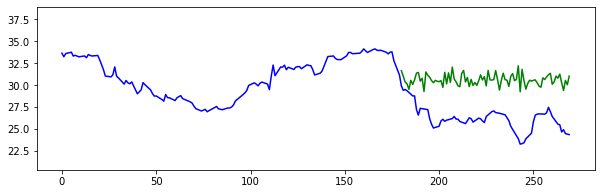

Mean for 0 month = 30.42366047211855
Mean for 1 month = 30.324316440654457
Mean for 2 month = 30.45824475593033


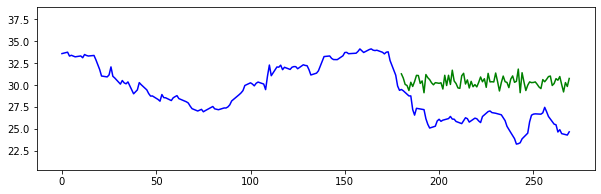

Mean for 0 month = 30.285686430550346
Mean for 1 month = 30.232830285590232
Mean for 2 month = 30.314207072158403


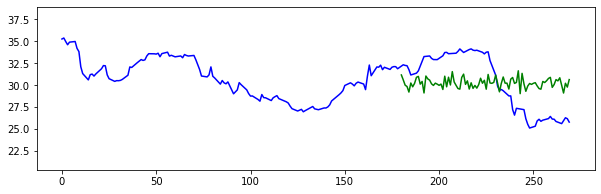

Mean for 0 month = 30.122113784333884
Mean for 1 month = 30.019366444465966
Mean for 2 month = 30.152717434121882


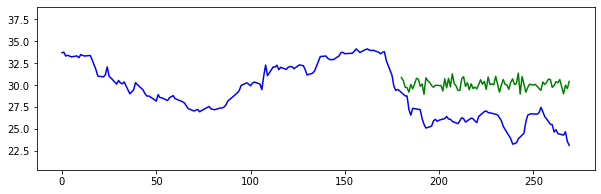

Mean for 0 month = 30.47842302565387
Mean for 1 month = 30.437194049695602
Mean for 2 month = 30.508003931933143


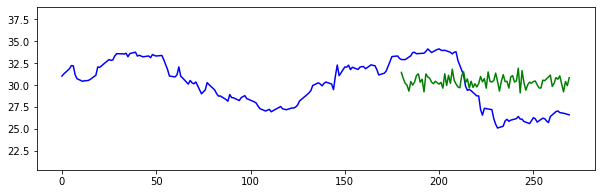

Mean for 0 month = 29.721337240592874
Mean for 1 month = 29.632867064361914
Mean for 2 month = 29.745294141518816


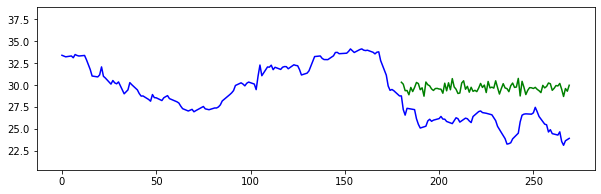

Mean for 0 month = 29.843296916494932
Mean for 1 month = 29.748398058839534
Mean for 2 month = 29.869292745183266


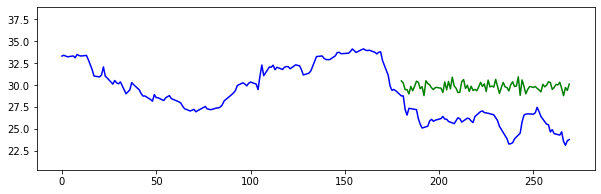

Mean for 0 month = 30.85101711853128
Mean for 1 month = 30.779806565865403
Mean for 2 month = 30.887832494044243


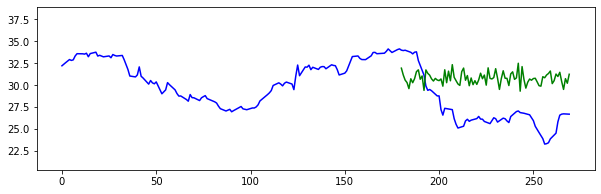

Mean for 0 month = 30.311422056925274
Mean for 1 month = 30.257836167045195
Mean for 2 month = 30.3400359733639


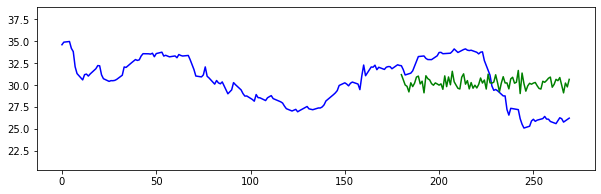

Mean for 0 month = 29.187911714249132
Mean for 1 month = 29.19155554720116
Mean for 2 month = 29.1985694475864


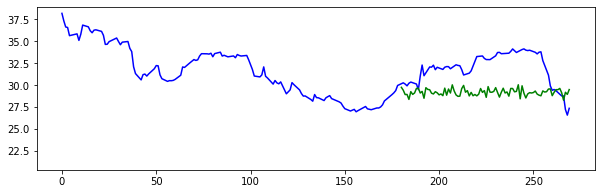

In [28]:
show_sample_predictions(regressorGRU)